# 1. Packages import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

%matplotlib inline

# 2. Data retrieval

In [2]:
def clean_sheet(dataframe):
    '''
    cleaning function for raw CSV import
    '''
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [3]:
def price_date_transform(CSV_date,index=False):
    '''
    Transform the CSV price style string into dateframe string style
    The CSV date follows US style which is MM/DD/YYYY
    '''
    if index==False:
        timestamp=pd.Timestamp(int(CSV_date[CSV_date.find("/",3)+1:]),
                            int(CSV_date[:CSV_date.find("/")]),
                            int(CSV_date[CSV_date.find("/",1)+1:CSV_date.find("/",3)]))
        return timestamp.strftime("%d/%b/%Y")
    else:
        timestamp=pd.Timestamp(int(CSV_date[-4:]),int(CSV_date[3:5]),int(CSV_date[:2]))
        return timestamp

In [4]:
def fundamental_date_transform(CSV_date):
    '''
    Transform the fundamental style string into dateframe string style
    CSV date follow following style yyyy-mm-dd or MM/DD/YYYY
    '''
    if '-' in CSV_date:
        timestamp=pd.Timestamp(int(CSV_date[:4]),
                            int(CSV_date[5:7]),
                            int(CSV_date[8:]))
    else:
        timestamp=pd.Timestamp(int(CSV_date[CSV_date.find("/",3)+1:]),
                               int(CSV_date[CSV_date.find("/",1)+1:CSV_date.find("/",3)]),
                               int(CSV_date[:CSV_date.find("/")]))        
    return timestamp

In [15]:
def CSV_price(region,start,end,VWAP):
    '''
    Grab the pricing data from CSV
    region= US, Europe,Asia,or Canada
    start,end are in year
    key is the reference to search
    return the target price dataframe with timestamp on the column
    '''
    mylist=[]
    for year in range(start,end+1):
        if VWAP==False:
            csv=pd.read_csv(r"C:\Users\Eric.Li\Documents\Post result data\{0} CSV\{0}_price_{1}.csv".format(region,year))
        else:
            csv=pd.read_csv(r"C:\Users\Eric.Li\Documents\Post result data\{0} CSV\{0}_VWAP_{1}.csv".format(region,year))
        data=csv.set_index("Ticker")
        adj_data=data.loc[[x for x in data.index if type(x)==str]].replace('#N/A N/A','').replace(' #N/A N/A ','').\
        replace("#N/A Invalid Security",'')
        adj_data=adj_data.loc[[x for x in adj_data.index if len(x)>0]]
        mylist.append(adj_data)

    price=pd.concat(mylist,axis=1,sort=True)
    price=price.apply(lambda x:pd.to_numeric(x),axis=1)
    
    csv_index=pd.read_csv(r"C:\Users\Eric.Li\Documents\Post result data\{0} CSV\{0}_price_index.csv".format(region))
    data_index=csv_index.set_index("Ticker").T
    price_index=data_index.replace('#N/A N/A','')
    #price_index=data_index.apply(lambda x:pd.to_numeric(x),axis=1)
    
    price.columns=[price_date_transform(i) for i in price.columns]
    '''
    Need to sort the columns for index price, and then transform to date string
    '''
    price_index.columns=[price_date_transform(i) for i in price_index.columns]
    #price_index=price_index.reindex(sorted(price_index.columns))
    #price_index.columns=[i.strftime("%d/%b/%Y") for i  in price_index.columns]
    
    abs_return=price.diff(1,axis=1)/price.shift(1,axis=1)
    abs_return_index=price_index.diff(1,axis=1)/price_index.shift(1,axis=1)
    return price,abs_return,price_index,abs_return_index

In [20]:
def CSV_EPS(region,start,end):
    '''
    Grab the pricing data from CSV database
    region= US, Europe,Asia,or Canada
    start,end are in year
    key is the reference to search
    return the target EPS dataframe with timestamp on the column
    '''
    mylist=[]
    for year in range(start,end+1):
        csv=pd.read_csv(r"C:\Users\Eric.Li\Documents\Post result data\{0} CSV\{0}_EPS_{1}.csv".format(region,year))
        data=csv.set_index("Ticker")
        adj_data=data.loc[[x for x in data.index if type(x)==str]].replace('#N/A N/A','').replace(" #N/A N/A ","")
        adj_data=adj_data.loc[[x for x in adj_data.index if len(x)>0]]
        mylist.append(adj_data)

    EPS=pd.concat(mylist,axis=1,sort=True)
    EPS=EPS.apply(lambda x:pd.to_numeric(x),axis=1)
    
    EPS.columns=[price_date_transform(i) for i in EPS.columns]
    return EPS

In [7]:
def revision_calc(ticker,date,EPS_df,period):
    '''
    Calculate revision from ticker and reference date
    '''
    if type(date)==pd.lib.tslib.NaTType:
        return None
    elif type(date)==pd.lib.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    
    if ticker in EPS_df.index:
        eps_series=EPS_df.loc[ticker]
        date_series=eps_series.index.tolist()
        if date in date_series:
            day0=date_series.index(date)
            post_series=eps_series.iloc[day0+period-1:day0+period+10]
            pre_series=eps_series.iloc[day0-10:day0]
            if len(post_series.dropna())==0 or len(pre_series.dropna())==0 or pre_series.dropna().iloc[-1]==0:
                revision=None
            else:
                try:
                    revision=np.divide(post_series.dropna().iloc[0],pre_series.dropna().iloc[-1])-1
                except:
                    revision=None
            return revision
        else:
            return None
    else:
        return None

In [8]:
def CSV_fundamentals(region,price,EPS_df,revision_period,min_history,min_vol,use_cache):
    '''
    Grab the fundamental data from the spreadsheet
    region= US, Europe,Asia,or Canada
    return the post result fundamental dataframe
    '''
    
    if use_cache is True:
        try:
            data=pd.read_csv(r'C:\Users\Eric.Li\Documents\Post result code\{0}{1}_clean_reg.csv'.format(region,\
                                                                                                        str(revision_period)))
            new_index=pd.MultiIndex.from_tuples(list(zip(data.iloc[:,0],data.iloc[:,1],data.iloc[:,2],data.iloc[:,3])))
            data.index=new_index
            target_data=data.iloc[:,4:]
        except:
            print("No such file!")
    else:
        csv=pd.read_csv(r'C:\Users\Eric.Li\Documents\Post result code\{0}.csv'.format(region))
        data=csv.set_index("Ticker").drop_duplicates().replace('#N/A Invalid Security','').\
        replace('#N/A Requesting Data...','')

        data=data[data.index!='']
        data=data.dropna(how="all")

        data["date_copy"]=[fundamental_date_transform(i) for i in data["Date"].copy()]
        data["ticker_copy"]=data.index
        data=data.copy().sort_values(by=["ticker_copy","date_copy"])
        data["next_date"]=data["date_copy"].shift(-1)
        data["ticker_copy"]=data["ticker_copy"].shift(-1)
        data["Date"]=data["date_copy"].copy().apply(lambda x: x.strftime("%d/%b/%Y") if x!='' else np.nan)
        data["Next"]=data.apply(lambda x: x["next_date"].strftime("%d/%b/%Y") if type(x["next_date"])==pd.Timestamp and \
                                x.name==x["ticker_copy"] else np.nan,axis=1)

#         data["period"]=data.apply(lambda x:str(pd.Timestamp(datetime.strptime(x["Date"],"%d/%b/%Y")).year)\
#                                             +" "+str(pd.Timestamp(datetime.strptime(x["Date"],"%d/%b/%Y")).quarter),\
#                                             axis=1)

        data["end_period"]=data.apply(lambda x: pd.offsets.BQuarterEnd().rollforward(x["date_copy"]).strftime("%d/%b/%Y"),\
                                      axis=1)

        data.index=pd.MultiIndex.from_tuples(list(zip(data.index,data["Date"],data["Next"],data["end_period"])))

        del data["ticker_copy"]
        del data["date_copy"]
        del data["next_date"]
        del data["Revision"]
        del data["end_period"]
        del data["Next"]

        for s in ["Market cap","Volume","SI","Broker"]:
            try:
                data[s]=pd.to_numeric(data[s])
            except KeyError:
                pass

        '''
        Add more realistic version of revision
        '''
        data["Revision_real"]=data.apply(lambda x: revision_calc(x.name[0],x.name[1],EPS_df,revision_period),axis=1)
        
        data["Revision_20"]=data.apply(lambda x: revision_calc(x.name[0],x.name[1],EPS_df,20),axis=1)
        data=data[(data["Revision_20"]>0)|(data["Revision_20"]<0)]

        '''
        take out data with zero or none revision/market cap
        '''
        data=data[(data["Revision_real"]>0)|(data["Revision_real"]<0)]
        data=data[(data["Market cap"]>500)] #universe above 500mn
        
        '''
        take out cases where there is a short history
        '''
        count_history=data.apply(lambda x: price.loc[x.name[0],:x.name[1]][-2*min_history:].count() if x.name[1] in \
                                   price.columns else None,axis=1)
        
        data=data.copy()[count_history>min_history]
        
        '''
        Add momentum
        '''
        data["mom"]=data.apply(lambda x: price.loc[x.name[0],:x.name[1]][-260:-23].dropna()[-1]/\
                               price.loc[x.name[0],:x.name[1]][-260:-23].dropna()[0] if x.name[1] in \
                               price.columns else None, axis=1)
        
        data=data[(data["mom"]>0)|(data["mom"]<0)]
        
        data["mom_short"]=data.apply(lambda x: price.loc[x.name[0],:x.name[1]][-24:-1].dropna()[-1]/\
                               price.loc[x.name[0],:x.name[1]][-24:-1].dropna()[0] if x.name[1] in \
                               price.columns else None, axis=1)      

        '''
        Add historic volatility
        '''
        
        abs_return=price.diff(1,axis=1)/price.shift(1,axis=1)
        
        data["30d_vol"]=data.apply(lambda x: abs_return.loc[x.name[0],:x.name[1]][-31:-1].std() if x.name[1] in \
                                   abs_return.columns else None,axis=1)      
        
        data=data[data["30d_vol"]>=min_vol]
        
        '''
        Final cleaning and export the data
        '''
        target_data=data.drop_duplicates()
        target_data.to_csv(r'C:\Users\Eric.Li\Documents\Post result code\{0}{1}_clean_reg.csv'.format(region,\
                                                                                                      str(revision_period)))
    return target_data

## 2.1 - US data

In [11]:
CSV_price??

In [13]:
US_price,abs_return_US,US_index_price,abs_return_index_US=CSV_price('US',2006,2019,False)

In [16]:
US_VWAP,abs_return_VWAP_US,US_index_VWAP,abs_return_VWAP_index_US=CSV_price('US',2006,2019,True)

In [21]:
US_EPS =CSV_EPS("US",2006,2019)

In [22]:
US1=CSV_fundamentals("US",US_price,US_EPS,1,120,0.005,True)

In [19]:
rel_return_US=abs_return_US-abs_return_index_US.loc["SPX Index"]

## 2.2 - Asian data

In [ ]:
# Asia index mmapping
Asia_mapping=clean_sheet(pd.read_csv("Asia mapping.csv")).dropna(how="all").iloc[:,:1]

In [ ]:
Asia_price,abs_return_Asia,Asia_index_price,abs_return_index_Asia=CSV_price('Asia',2010,2019,False)

In [ ]:
Asia_EPS=CSV_EPS("Asia",2010,2019)

In [ ]:
Asia2_old=CSV_fundamentals("Asia",abs_return_Asia,Asia_EPS,2,"old")

In [ ]:
Asia2_new=CSV_fundamentals("Asia",abs_return_Asia,Asia_EPS,2,"new")

## 2.3 - European data

In [ ]:
Europe_price,abs_return_Europe,Europe_index_price,abs_return_index_Europe=CSV_price('Europe',2010,2019,False)

In [ ]:
Europe_VWAP,abs_return_VWAP_Europe,Europe_index_VWAP,abs_return_index_Europe=CSV_price('Europe',2010,2019,True)

In [ ]:
Europe_EPS=CSV_EPS("Europe",2010,2019)

In [ ]:
Europe2_old=CSV_fundamentals("Europe",abs_return_Europe,Europe_EPS,2,'old')

In [ ]:
Europe2_new=CSV_fundamentals("Europe",abs_return_Europe,Europe_EPS,2,'new')

# 3. Utility functions

In [14]:
def return_calc(ticker,date,price_df,index_df,period_tuple,abs_rel):
    '''
    Calculate return from the period tuple, abs_return if assigned abs
    Day starts from zero, so 1 means start the return calculation one day after result, second element is the number of days
    '''
    if type(date)==pd.tslib.NaTType:
        return None
    elif type(date)==pd.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    price_series=price_df.loc[ticker].dropna()
    date_series=price_series.index.tolist()
    
    index_data_series=index_df.index.tolist()
    
    if date in date_series:
        day0=date_series.index(date)
        day0_index=index_data_series.index(date)
        
        start_price=price_series.iloc[:day0+period_tuple[0]].dropna().iloc[-1]
        end_price=price_series.iloc[:day0+period_tuple[0]+period_tuple[1]].dropna().iloc[-1]
        
        target_series=price_series.iloc[day0+period_tuple[0]-2:day0+period_tuple[0]+period_tuple[1]]
        
        if start_price!=0:
            abs_return=end_price/start_price-1
        else:
            abs_return=None
        

        
        if abs_rel=='abs':
            target_return=abs_return
        else:

            start_index=index_df.iloc[:day0_index+period_tuple[0]].dropna().iloc[-1]
            end_index=index_df.iloc[:day0_index+period_tuple[0]+period_tuple[1]].dropna().iloc[-1]
            if start_index!=0:
                index_return=end_index/start_index-1
            else:
                index_return=None

            if abs_return is None or index_return is None:
                target_return=None
            else:
                target_return=abs_return-index_return
        return target_return
    else:
        return None

In [15]:
def quarter_transform(quarter):
    '''
    Take the raw quarter to Q1 to Q4
    '''
    if type(quarter)==float:
        adj_quarter=None
    else:
        
        if quarter[-2:]=='Q4' or quarter[-2:]==':A':
            adj_quarter='Q4'
        elif quarter[-2:]=='Q3' or quarter[-2:]=='C3':
            adj_quarter='Q3'
        elif quarter[-2:]=='Q2' or quarter[-2:]=='C2' or quarter[-2:]=='S1':
            adj_quarter='Q2'
        elif quarter[-2:]=='Q1' or quarter[-2:]=='C1':
            adj_quarter='Q1'
        else:
            adj_quarter=None
    return adj_quarter
    
    

In [164]:
def data_cleaning_regression(fundamental_df,price_df,index_df,pre_period,EAR_period,target_period):
    ''' 
    Enhance the existing fundamental data after CSV_fundamental function
    Variables include pre_announcement return, EAR, target_return, Sector dummy, adjusted quarter
    Also transform some data to make it closer to normal distribution
    The starting day should be 
    '''
    fundamental_df["adj_quarter"]=fundamental_df.apply(lambda x:quarter_transform(x["Quarter"]),axis=1)
    
    fundamental_df["pre_return"]=fundamental_df.apply(lambda x:return_calc(x.name[0],x.name[1],price_df,index_df,\
                                                                                   (-pre_period-2,pre_period),'rel'),axis=1)
    
    fundamental_df["EAR"]=fundamental_df.apply(lambda x:return_calc(x.name[0],x.name[1],price_df,index_df,\
                                                                                   (-1,EAR_period),'rel'),axis=1)  

    fundamental_df["post_return"]=fundamental_df.apply(lambda x:return_calc(x.name[0],x.name[1],price_df,index_df,\
                                                                                   (EAR_period-1,target_period),'rel'),axis=1)
    
    for i in fundamental_df["Supersector"].dropna().unique():
        fundamental_df[i]=(fundamental_df["Supersector"]==i)*1.0
        
    for i in fundamental_df["adj_quarter"].dropna().unique():
        fundamental_df[i]=(fundamental_df["adj_quarter"]==i)*1.0    
    
    fundamental_df["Revision_real"][fundamental_df["Revision_real"]>0.99]=0.99
    fundamental_df["Revision_real"][fundamental_df["Revision_real"]<-0.99]=-0.99
    
    fundamental_df["mom"]=np.log(fundamental_df["mom"])
    
    return fundamental_df
    

In [480]:
def EAR_calc(ticker,date,return_df,EAR_period,vol_lookback):
    '''
    Calculate EAR from ticker and reference date
    '''
    if type(date)==pd.tslib.NaTType:
        return None
    elif type(date)==pd.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    return_series=return_df.loc[ticker].dropna()
    date_series=return_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        post_series=return_series.iloc[day0:]
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=(return_series.iloc[day0:day0+EAR_period]+1).prod()-1
        nmove=ret/vol
        return nmove
    else:
        return None

In [481]:
def signal_vol(signal_column,return_df,vol_lookback):
    '''
    Calculate simple vol from signal tuple
    '''
    signal_series=return_df.loc[signal_column.name[0]]
    location=signal_series.index.tolist().index(signal_column.name[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [792]:
def slice_universe(signal_df,start_datetime,end_datetime,old_position):
    '''
    Slice the signal_df, both the index and entry date have to be 
    '''
    

    signal_df=signal_df.loc[start_datetime:end_datetime]
    
    if old_position is True:  
        adj_signal_df=signal_df
    else:
        entry=signal_df.apply(lambda x:datetime.strptime(x.name[1],"%d/%b/%Y"),axis=0)
        period_evaluate=(entry>=start_datetime)&(entry<=end_datetime)
        adj_signal_df=signal_df.loc[:,period_evaluate]
    
    
    zero_index=pd.Series(1,index=pd.date_range(start_datetime,end_datetime,freq='B')).to_frame()
    adj_signal_df=pd.concat([adj_signal_df.drop_duplicates(),zero_index],axis=1).iloc[:,:-1]
    return adj_signal_df
    

In [793]:
def signal_filter_stop(signal_df,stop_level,return_df,vol_lookback,stop_type,index_df):
    '''
    Input - signal_df
    Get the updated signal df after the stop loss
    stop_type:abs,rel
    
    '''
    if stop_type=='abs':
        vol_row=signal_df.apply(lambda column:signal_vol(column,return_df,vol_lookback),axis=0)
        signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
        signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    elif stop_type=='rel':
        if index_df.shape[1]==1:
            signal_count=signal_df.copy()
            signal_count[((signal_count)>0) | ((signal_count)<0)]=1.0
            signal_hedge=signal_count.apply(lambda x:x.multiply(index_df.iloc[:,0],axis=0))
            
            vol_row=signal_df.apply(lambda x:signal_vol(x,return_df,vol_lookback),axis=0)
            rel_signal_cum_nmove=((1+signal_df).cumprod()-(1+signal_hedge).cumprod()).ffill()/vol_row
            signal_df_stop=signal_df[-(rel_signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
        else:
            signal_count=signal_df.copy()
            signal_count[((signal_count)>0) | ((signal_count)<0)]=1.0
            signal_hedge=signal_count.apply(lambda x:x.multiply(index_df[Asia_mapping.loc[x.name[0][-2:]].iloc[0]],axis=0))
            
            vol_row=signal_df.apply(lambda x:signal_vol(x,return_df,vol_lookback),axis=0)
            rel_signal_cum_nmove=((1+signal_df).cumprod()-(1+signal_hedge).cumprod()).ffill()/vol_row
            signal_df_stop=signal_df[-(rel_signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]            
            
    else:
        pass
        
    return signal_df_stop

In [794]:
def revision_adjusted_size(reference_signal_df,lower_revision,higher_revision,size_multiple,revision_row,revision_row_reference,gross,long):
    
    ''' 
    Use positive size
    '''
    
    lower_size=0.01
    higher_size=lower_size*size_multiple
    
    if long is True:
        
        size_row_reference=revision_row_reference.to_frame().copy().apply(lambda x: lower_size+(higher_size-lower_size)\
                                                      *(np.abs(x.iloc[0]-lower_revision))/np.abs(higher_revision-lower_revision) \
                                                      if np.abs(x.iloc[0])<=np.abs(higher_revision) else higher_size,axis=1)

        size_df_reference=(1+reference_signal_df).cumprod()*size_row_reference

        trial_gross=np.abs(size_df_reference.sum(axis=1).mean())
        new_lower_size=lower_size/(trial_gross*100/gross)
        new_higher_size=higher_size/(trial_gross*100/gross)

        size_row=revision_row.to_frame().copy().apply(lambda x: new_lower_size+(new_higher_size-new_lower_size)\
                                                      *(np.abs(x.iloc[0]-lower_revision))/np.abs(higher_revision-lower_revision) \
                                                      if np.abs(x.iloc[0])<=np.abs(higher_revision) else new_higher_size,axis=1)
    else:
        size_row_reference=revision_row_reference.to_frame().copy().apply(lambda x: lower_size+(higher_size-lower_size)\
                                                      *(np.abs(x.iloc[0]-lower_revision))/np.abs(higher_revision-lower_revision) \
                                                      if np.abs(x.iloc[0])<=np.abs(lower_revision) else higher_size,axis=1)

        size_df_reference=(1-reference_signal_df).cumprod()*size_row_reference

        trial_gross=np.abs(size_df_reference.sum(axis=1).mean())
        new_lower_size=lower_size/(trial_gross*100/gross)
        new_higher_size=higher_size/(trial_gross*100/gross)

        size_row=revision_row.to_frame().copy().apply(lambda x: new_lower_size+(new_higher_size-new_lower_size)\
                                                      *(np.abs(x.iloc[0]-lower_revision))/np.abs(higher_revision-lower_revision) \
                                                      if np.abs(x.iloc[0])<=np.abs(lower_revision) else new_higher_size,axis=1)

    return size_row, new_lower_size

In [920]:
def sizing(signal_df,reference_signal_df,gross,fundamental_df,new_signal,return_df,risk_parity,liquidity,capital,\
           revision_adjust,long):
    '''
    Use historical signal_df range to calculate the size row for the current signal_df range
    Idea is to use historical as a benchmark for future sizing
    '''
    
    fundamental_df=fundamental_df.copy().sort_index()
    vol_reference=reference_signal_df.apply(lambda x:signal_vol(x,return_df,30),axis=0).mean()
    vol_row=signal_df.apply(lambda x:signal_vol(x,return_df,30),axis=0)
    
    '''
    Revision row needs to be updated using reference_signal
    new sizing scheme is a linear function
    revision_adjust=(True/False,lower_revision,higher_revision,size_multiple)
    '''
    
    if revision_adjust[0] is True:
        
        if new_signal is True:     
            revision_row_reference=reference_signal_df.apply(lambda x:fundamental_df.loc[x.name,"Revision_real"],axis=0)
            revision_row=signal_df.apply(lambda x:fundamental_df.loc[x.name,"Revision_real"],axis=0)
        else:
            revision_row_reference=reference_signal_df.apply(lambda x:fundamental_df.loc[x.name,"Revision_20"],axis=0)
            revision_row=signal_df.apply(lambda x:fundamental_df.loc[x.name,"Revision_20"],axis=0)            
        
        if long is True and revision_adjust[1] is not None:
            lower_revision=revision_adjust[1][0]
            higher_revision=revision_adjust[1][1]
            size_multiple=revision_adjust[3]
        
            base_size,low_size=revision_adjusted_size(reference_signal_df,lower_revision,higher_revision,size_multiple,\
                                                      revision_row,revision_row_reference,gross,True)
            if risk_parity is True:
                size_row=signal_df.apply(lambda x: min(base_size[x.name]/(vol_row[x.name]/vol_reference),\
                                                       fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]*\
                                                       liquidity/capital),axis=0)
            else:
                size_row=signal_df.apply(lambda x: min(base_size[x.name], fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]\
                                                       *liquidity/capital),axis=0)            

        elif long is False and revision_adjust[2] is not None:
            lower_revision=revision_adjust[2][0]
            higher_revision=revision_adjust[2][1]
            size_multiple=revision_adjust[3]
        
            base_size,low_size=revision_adjusted_size(reference_signal_df,lower_revision,higher_revision,size_multiple,revision_row,\
                                             revision_row_reference,gross,False) 

            if risk_parity is True:
                size_row=signal_df.apply(lambda x: min(base_size[x.name]/(vol_row[x.name]/vol_reference),\
                                                       fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]*\
                                                       liquidity/capital),axis=0)
            else:
                size_row=signal_df.apply(lambda x: min(base_size[x.name], fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]\
                                                       *liquidity/capital),axis=0)

        else:
            size_row=None
            low_size=None

    elif revision_adjust[0]=='constant':
        if risk_parity is True:
            size_row=signal_df.apply(lambda x: min(revision_adjust[1]/(vol_row[x.name]/vol_reference),\
                                                   fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]*\
                                                   liquidity/capital),axis=0)
        else:
            size_row=signal_df.apply(lambda x: min(revision_adjust[1], fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]\
                                                   *liquidity/capital),axis=0)
        low_size=None

    else:
        number=reference_signal_df.count(axis=1).mean()
        avg_size=gross/100/number

        if risk_parity is True:
            size_row=signal_df.apply(lambda x: min(avg_size/(vol_row[x.name]/vol_reference),\
                                                   fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]*\
                                                   liquidity/capital),axis=0)
        else:
            size_row=signal_df.apply(lambda x: min(avg_size, fundamental_df.loc[x.name[0],x.name[1]]["Volume"].iloc[0]\
                                                   *liquidity/capital),axis=0)
        low_size=None
    return size_row,low_size

In [796]:
def trading_analytics_date(portfolio_cache):
    '''
    Key portfolio metrics from portfolio cache
    Feed into plot function
    '''
    
    ind_return=portfolio_cache[3]
    signal_count=len(ind_return)
    account_curve=portfolio_cache[1]
    
    if signal_count==0:
        return None,None,None,None,None,None,None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=(account_price.iloc[-1]**(1/len(account_price)))**260-1
        ann_sharpe=ann_ret/ann_vol
        
        max_dd=-((1+account_curve)-(1+account_curve).cummax(axis=0)).expanding().min().min()
        
        #low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        #high_date=account_curve[:low_date].idxmax()
        #max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [797]:
def trading_analytics_simp(account_curve):
    '''
    Key portfolio metrics from portfolio account curve
    Only sharpe and drawdown
    '''


    account_price=account_curve+1
    ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
    ann_ret=(account_price.iloc[-1]**(1/len(account_price)))**260-1
    ann_sharpe=ann_ret/ann_vol

    max_dd=-((1+account_curve)-(1+account_curve).cummax(axis=0)).expanding().min().min()

    #low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
    #high_date=account_curve[:low_date].idxmax()
    #max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])

    return ann_sharpe,max_dd

In [798]:
def plot_signal(title,figsize,portfolio_cache):

    account_curve=portfolio_cache[1]
    avg_size=np.abs(portfolio_cache[2]).mean(axis=0).mean()
    ind_return=portfolio_cache[3]
    gross=portfolio_cache[4]
    turnover=portfolio_cache[5]

    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.01))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])

    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])

    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(portfolio_cache)

    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Exposure')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2],loc=2)
    ax1.axhline(y=0,color='k')

    plt.show()        

# 4. Linear regression - US

## 4.1 Data enhancement and cleaning

In [165]:
target_US=data_cleaning_regression(US1.copy(),US_price,US_index_price.loc['SPX Index'],10,3,20)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [166]:
target_US=target_US.dropna(how='any',axis=0)

## 4.2 Linear regression

In [167]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [189]:
x=target_US[['Volume','Revision_real','mom','30d_vol','pre_return','EAR','Broker','SI']+\
            target_US["Supersector"].dropna().unique().tolist()+\
          target_US["adj_quarter"].dropna().unique().tolist() ]
y=target_US['post_return']

In [170]:
target_US.corr().to_csv("corr.csv")

In [172]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [173]:
regr = LinearRegression()

In [174]:
regr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [175]:
rmse = np.sqrt(mean_squared_error(y_test,regr.predict(x_test)))
r2 = r2_score(y_test,regr.predict(x_test))
rmse_train = np.sqrt(mean_squared_error(y_train,regr.predict(x_train)))
r2_train = r2_score(y_train,regr.predict(x_train))
print(rmse)
print(r2)
print(rmse_train)
print(r2_train)

0.08746047748912351
0.017473680874817155
0.08358445138275897
0.03487325647153239


In [176]:
rmse = np.sqrt(mean_squared_error(y_test,regr.predict(x_test)))
r2 = r2_score(y_test,regr.predict(x_test))
rmse_train = np.sqrt(mean_squared_error(y_train,regr.predict(x_train)))
r2_train = r2_score(y_train,regr.predict(x_train))
print(rmse)
print(r2)
print(rmse_train)
print(r2_train)

0.08746047748912351
0.017473680874817155
0.08358445138275897
0.03487325647153239


In [177]:
train_result=y_train.to_frame().copy()
train_result["predict"]=regr.predict(x_train)

In [178]:
test_result=y_test.to_frame().copy()
test_result["predict"]=regr.predict(x_test)

In [179]:
test_result.shape

(13943, 2)

In [180]:
test_result.describe()

,post_return,predict
count,13943.000000,13943.000000
mean,0.004841,0.003316
std,0.088238,0.016162
min,-0.656633,-0.364777
25%,-0.037972,-0.003148
50%,0.002613,0.003921
75%,0.043091,0.010872
max,1.461976,0.243744


In [181]:
test_result[test_result["predict"]>0.005].shape

(6352, 2)

In [182]:
test_result[test_result["predict"]<-0.00].sort_values("post_return").mean()

post_return   -0.003661
predict       -0.011047
dtype: float64

In [183]:
import statsmodels.api as sm

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [184]:
model=sm.OLS(y_test,x_test).fit()

In [185]:
model.summary()

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            post_return   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.966
Date:                Tue, 25 Jun 2019   Prob (F-statistic):           7.79e-55
Time:                        15:21:27   Log-Likelihood:                 14488.
No. Observations:               13943   AIC:                        -2.840e+04
Df Residuals:                   13655   BIC:                        -2.623e+04
Df Model:                         287                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.004      0.325      0.745      -0.007       0.010
x1         -6.337e-06    2.8e-05     -0.227      0.821   -6.11e-05    4.85e-05
x2             0.0216      0.019      1.148      0.251      -0.015       0.058
x3             0.0096      0.006      1.636      0.102      -0.002       0.021
x4             0.0132      0.186      0.071      0.943      -0.351       0.377
x5            -0.0003      0.034     -0.008      0.994      -0.067       0.067
x6            -0.0145      0.025     -0.574      0.566      -0.064       0.035
x7            -0.0003      0.000     -0.603      0.547      -0.001       0.001
x8             0.0009      0.000      1.846      0.065   -5.42e-05       0.002
x9            -0.0112      0.007     -1.532      0.126      -0.026       0.003
x10            0.0020      0.005      0.414      0.679      -0.008       0.012
x11           -0.0084      0.004     -2.115      0.034      -0.016      -0.001
x12           -0.0064      0.005     -1.199      0.231      -0.017       0.004
x13           -0.0079      0.005     -1.654      0.098      -0.017       0.001
x14           -0.0004      0.003     -0.112      0.911      -0.007       0.006
x15           -0.0133      0.010     -1.298      0.194      -0.033       0.007
x16            0.0056      0.005      1.084      0.278      -0.005       0.016
x17            0.0051      0.006      0.857      0.392      -0.007       0.017
x18            0.0023      0.003      0.710      0.478      -0.004       0.009
x19            0.0063      0.005      1.329      0.184      -0.003       0.016
x20            0.0053      0.007      0.809      0.419      -0.008       0.018
x21            0.0080      0.012      0.678      0.498      -0.015       0.031
x22            0.0026      0.005      0.528      0.598      -0.007       0.012
x23            0.0195      0.008      2.380      0.017       0.003       0.036
x24           -0.0117      0.017     -0.703      0.482      -0.044       0.021
x25           -0.0010      0.007     -0.136      0.892      -0.016       0.014
x26            0.0003      0.008      0.031      0.976      -0.016       0.017
x27            0.0047      0.008      0.590      0.555      -0.011       0.020
x28           -0.0029      0.003     -1.121      0.262      -0.008       0.002
x29            0.0088      0.003      3.430      0.001       0.004       0.014
x30           -0.0004      0.003     -0.145      0.884      -0.005       0.005
x31           -0.0041      0.003     -1.591      0.112      -0.009       0.001
x32         2.891e-09   1.71e-09      1.686      0.092   -4.71e-10    6.25e-09
x33         -4.94e-05   6.73e-05     -0.734      0.463      -0.000    8.26e-05
x34        -1.789e-05   1.34e-05     -1.332      0.183   -4.42e-05    8.44e-06
x35           -0.0002      0.000     -0.535      0.593      -0.001       0.001
x3

## 4.3 Build the signal

In [49]:
class regression_signal(object):
    def __init__(self,long_cutoff,short_cutoff,fundamental_df,price_df,index_price_df,entry,holding,
                 start,end,old_position,revision_adjust,new_signal):
        
        self.long_cutoff=long_cutoff
        self.short_cutoff=short_cutoff  
        self.fundamental_df=fundamental_df.dropna(how='any',axis=0)
        self.price_df=price_df
        self.abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
        self.index_price_df=index_price_df
        self.entry=entry
        self.holding=holding
        self.start=start
        self.end=end
        self.old_position=old_position
        self.revision_adjust=revision_adjust
        self.new_signal=new_signal

    def clean_variable(self):
        ''' 
        Enhance the existing fundamental data after CSV_fundamental function
        Variables include pre_announcement return, EAR, target_return, Sector dummy, adjusted quarter
        Also transform some data to make it closer to normal distribution
        '''
         
        x=self.fundamental_df[['Volume','Revision_real','mom','30d_vol','pre_return','EAR','Broker','SI']+\
                    target_US["Supersector"].dropna().unique().tolist()+\
                  target_US["adj_quarter"].dropna().unique().tolist() ]
        
        y=self.fundamental_df['post_return']
        
        
        self.x=x
        self.y=y
        
        return x,y

    def regression_signal(self):
        '''
        Build the target signal dataframe from regression result
        '''
        
        try:
            x=self.x.copy()
            y=self.y.copy()
        except:
            x,y=self.clean_variable()
        
        long_base=pd.DataFrame()
        short_base=pd.DataFrame()

        year_series=x.apply(lambda x:int(x.name[1][-4:]),axis=1)
        regression_dict={}

        for i in year_series.unique():

            x_year=x.loc[year_series==i,:]
            y_year=y.loc[year_series==i,:].to_frame()

            regr=LinearRegression()
            regr.fit(x_year,y_year)
            upper_predict=min(pd.DataFrame(regr.predict(x_year)).quantile(self.long_cutoff).iloc[0],0.02)
            lower_predict=max(pd.DataFrame(regr.predict(x_year)).quantile(self.short_cutoff).iloc[0],-0.02)
            regression_dict[i]=[regr,upper_predict,lower_predict]
            
            if i==year_series.unique().min():
                pass
            else:
                y_year["predict"]=regression_dict[i-1][0].predict(x_year)
                    

                long_base_year=y_year[y_year["predict"]>regression_dict[i-1][1]]
                short_base_year=y_year[y_year["predict"]<regression_dict[i-1][2]]

                long_base=pd.concat([long_base,long_base_year],axis=0)
                short_base=pd.concat([short_base,short_base_year],axis=0)
        
        self.long_base=long_base
        self.short_base=short_base
        
        return long_base,short_base,regression_dict    


    def signal_df_date(self):
        '''
        Obtain the signal_df function over the whole time period from the target signal list
        '''
        try:
            long_base=self.long_base.copy()
            short_base=self.short_base.copy()
        except:
            long_base,short_base=signal.regression_signal(self)
        
        if long_base is None:
            long_df=None
        
        else:
            long_df=pd.DataFrame(index=self.price_df.columns)

            for s in long_base.index:
                return_series=self.abs_return.loc[s[0]]
                if s[1] in return_series.index:
                    if not np.isnan(return_series.loc[s[1]]): 
                        day0=return_series.index.tolist().index(s[1])
                            
                        if type(s[2])==float:##basically np.nan has type float
                            period=self.holding+1
                        
                        else: ##assume that we are not holding through numbers
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y").date(),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y").date())-self.entry)
                            
                        if period is None:
                            pass
                        else:
                            target_series=return_series.iloc[day0+self.entry-1:day0+min(period+self.entry, \
                                                                                           len(return_series[day0:]))].dropna()
                            
                            if len(target_series)==0:
                                pass
                            else:
                                target_series.iloc[0]=0.0
                                long_df[s]=target_series                        

                    else:
                        pass
                else:
                    pass
                
            long_df=long_df.reindex(datetime.strptime(i,"%d/%b/%Y") for i in long_df.index)
            long_df=long_df.sort_index()

            if self.start is not None:
                long_df=slice_universe(long_df,self.start,self.end,self.old_position)
            else:
                pass
            
            long_df=long_df.dropna(how="all",axis=1)
            #long_df.columns=pd.MultiIndex.from_tuples(pd.Series(list(long_df.columns)))
            self.long_df=long_df
            
            
        
        if short_base is None:
            short_df=None
        
        else:
            short_df=pd.DataFrame(index=self.price_df.columns)

            for s in short_base.index:
                return_series=self.abs_return.loc[s[0]]
                if s[1] in return_series.index:
                    if not np.isnan(return_series.loc[s[1]]): 
                        day0=return_series.index.tolist().index(s[1])
                        
                        if type(s[2])==float:##basically np.nan has type float
                            period=self.holding
                    
                        else: ##assume that we are not holding through numbers
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y").date(),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y").date())-self.entry)\


                        if period is None:
                            pass
                        else:
                            target_series=return_series.iloc[day0+self.entry-1:day0+min(period+self.entry, \
                                                                                           len(return_series[day0:]))].dropna()
                            
                            if len(target_series)==0:
                                pass
                            else:
                                target_series.iloc[0]=0.0
                                short_df[s]=target_series         
                            
                    else:
                        pass
                else:
                    pass

            short_df=short_df.reindex(datetime.strptime(i,"%d/%b/%Y") for i in short_df.index)
            short_df=short_df.sort_index()

            if self.start is not None:
                short_df=slice_universe(short_df,self.start,self.end,self.old_position)
            else:
                pass  
            
            short_df=short_df.dropna(how="all",axis=1)
            #short_df.columns=pd.MultiIndex.from_tuples(pd.Series(list(short_df.columns)))
            self.short_df=short_df
        
        return long_df,short_df

    def signal_account(self,stop,gross,index_df,net_level,risk_parity,liquidity,capital):
        '''
        Build the account curve with signal_df
        Assume quarterly rebalancing that's why the period list has quarter as the key
        Take extra care when building the account curve, the logic is: work out the size_df, then shift by 1 and * signal_df
        Stop=(long_stop,short_stop,type)
        index_df has to be a dataframe with a name
        '''
        
        try:
            long_df=self.long_df.copy()
            short_df=self.short_df.copy()
            
        except:
            long_df,short_df=self.signal_df_date()
                   
        '''
        Assign values for later use
        '''
        
        self.capital=capital
        
        self.index_df=index_df
        self.index_df.index=[datetime.strptime(i,"%d/%b/%Y") for i in self.index_df.index]
       
        
        '''
        Define rebalance period first
        '''
        if long_df is None:
            period_year=short_df.apply(lambda x:str(x.name.year),axis=1)
            period_list=list(set(period_year))
            period_list.sort()    
            
        else:
            period_year=long_df.apply(lambda x:str(x.name.year),axis=1)
            period_list=list(set(period_year))
            period_list.sort()    
                
        '''
        Separate out long and short
        '''
        if long_df is None:
            long_cache=(None,None,None,None)
        else:
            if stop is None:
                pass
            else:
                long_df=signal_filter_stop(long_df,stop[0],self.abs_return,30,stop[2],self.index_df)   
                self.long_df=long_df

            long_sub_signal={}
            long_sub_size_row={}
            long_sub_size_df={}
            long_sub_pnl={}
        
            for s in period_list:
            
                long_sub_signal[s]=long_df[period_year==s].dropna(how='all',axis=1)
                
                if long_sub_signal[s].shape[1]==0:
                    long_sub_size_df[s]=long_sub_signal[s]
                    long_sub_pnl[s]=long_sub_signal[s]
                    
                else:
                    if period_list.index(s)<4:##use last quarter's sizing as reference
                        long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[s],gross[0],self.fundamental_df,\
                                                       self.new_signal,self.abs_return,risk_parity,liquidity,capital,\
                                                    self.revision_adjust,True)[0]
                    else:
                        try:
                            long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[period_list[period_list.index(s)-1]],\
                                                       gross[0],self.fundamental_df,self.new_signal,self.abs_return,\
                                                        risk_parity,liquidity,capital,self.revision_adjust,True)[0]
                        except:
                            long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[s],\
                                                       gross[0],self.fundamental_df,self.new_signal,self.abs_return,\
                                                        risk_parity,liquidity,capital,self.revision_adjust,True)[0] 

                    long_sub_size_df[s]=(1+long_sub_signal[s]).cumprod()*long_sub_size_row[s]
                    long_sub_pnl[s]=(long_sub_size_df[s].shift(1))*long_sub_signal[s] 
                    # need to shift by 1 as the size is end of the day
        
            long_daily_pnl=pd.concat(list(long_sub_pnl.values()),axis=0)
            long_acct_curve=long_daily_pnl.cumsum().ffill().sum(axis=1)
            long_size_df=pd.concat(list(long_sub_size_df.values()),axis=0)
            long_ind_return=long_daily_pnl.cumsum().ffill().iloc[-1].dropna()
            long_cache=(long_daily_pnl,long_acct_curve,long_size_df,long_ind_return)
            
            self.long_cache=long_cache

            
        if short_df is None:
            short_cache=(None,None,None,None)
        else:
            if stop is None:
                pass
            else:
                short_df=-signal_filter_stop(-short_df,stop[1],self.abs_return,30,stop[2],self.index_df)   
                self.short_df=short_df

            short_sub_signal={}
            short_sub_size_row={}
            short_sub_size_df={}
            short_sub_pnl={}
        
            for s in period_list:
                short_sub_signal[s]=short_df[period_year==s].dropna(how='all',axis=1)

                if short_sub_signal[s].shape[1]==0:
                    short_sub_size_df[s]=short_sub_signal[s]
                    short_sub_pnl[s]=short_sub_signal[s]
                    
                else:
                    
                    if period_list.index(s)<4:##use last quarter's sizing as reference
                        short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal[s],gross[1],self.fundamental_df,\
                                                       self.new_signal,self.abs_return,risk_parity,liquidity,capital,\
                                                      self.revision_adjust,False)[0]
                    else:
                        try:
                            short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal\
                                                          [period_list[period_list.index(s)-1]],\
                                                           gross[1],self.fundamental_df,self.new_signal,self.abs_return,\
                                                          risk_parity,liquidity,\
                                                          capital,self.revision_adjust,False)[0]
                        except:
                            short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal[s],\
                                                           gross[1],self.fundamental_df,self.new_signal,self.abs_return,\
                                                          risk_parity,liquidity,\
                                                          capital,self.revision_adjust,False)[0]

                    short_sub_size_df[s]=(1+short_sub_signal[s]).cumprod()*short_sub_size_row[s]
                    short_sub_pnl[s]=(short_sub_size_df[s].shift(1))*short_sub_signal[s] 
                # need to shift by 1 as the size is end of the day
        
            short_daily_pnl=pd.concat(list(short_sub_pnl.values()),axis=0)
            short_acct_curve=short_daily_pnl.cumsum().ffill().sum(axis=1)
            short_size_df=pd.concat(list(short_sub_size_df.values()),axis=0)
            short_ind_return=short_daily_pnl.cumsum().ffill().iloc[-1].dropna()
            
            short_cache=(short_daily_pnl,short_acct_curve,short_size_df,short_ind_return)
            self.short_cache=short_cache
    
        '''Put alpha positions together to form the alpha part'''
        alpha_df=pd.concat([long_df,short_df],axis=1)
        self.alpha_df=alpha_df
        
        alpha_daily_pnl=pd.concat([long_cache[0],short_cache[0]],axis=1)
        alpha_acct_curve=alpha_daily_pnl.cumsum().ffill().sum(axis=1)
        alpha_size_df=pd.concat([long_cache[2],short_cache[2]],axis=1)
        alpha_ind_return=pd.concat([long_cache[3],short_cache[3]],axis=0)
        
        alpha_cache=(alpha_daily_pnl,alpha_acct_curve,alpha_size_df,alpha_ind_return)
        
        
        if self.index_df is not None:
            if self.index_df.shape[1]==1:
                index_df=self.index_df.copy().loc[alpha_df.index] 
                index_size_df=(net_level-alpha_size_df.sum(axis=1)).to_frame(index_df.columns[0])
                index_daily_pnl=index_size_df.shift(1)*index_df
                index_acct_curve=index_daily_pnl.cumsum()
                index_ind_return=index_acct_curve.iloc[-1]
                index_cache=(index_daily_pnl,index_acct_curve,index_size_df,index_ind_return)
            else:
                index_df=self.index_df.copy().loc[alpha_df.index] 
                alpha_temp=alpha_cache[2].copy().T
                alpha_temp["index"]=alpha_temp.apply(lambda x:Asia_mapping.loc[x.name[0][-2:]].iloc[0],axis=1)
                index_size_df=net_level-alpha_temp.groupby("index").apply(sum).T.iloc[:-1]
                index_daily_pnl=index_size_df.shift(1)*index_df
                index_acct_curve=index_daily_pnl.cumsum()
                index_ind_return=index_acct_curve.iloc[-1]
                index_cache=(index_daily_pnl,index_acct_curve,index_size_df,index_ind_return)
        else:
            index_cache=(None,None,None,None)
            
        '''Finally put everything together'''    
        portfolio_df=pd.concat([alpha_df,index_df],axis=1)
            
        portfolio_size_df=pd.concat([alpha_cache[2],index_cache[2]],axis=1).sort_index()
  
        portfolio_daily_pnl=pd.concat([alpha_cache[0],index_cache[0]],axis=1).sort_index()

        portfolio_acct_curve=portfolio_daily_pnl.cumsum().ffill().sum(axis=1)
        portfolio_ind_return=alpha_cache[3].copy()
        
        portfolio_gross=np.abs(portfolio_size_df).sum(axis=1).sort_index()
        portfolio_turnover=(np.abs(alpha_size_df.fillna(0.0).diff(1)).sum().sum())/(portfolio_size_df.shape[0]/260)
        
        portfolio_cache=(portfolio_daily_pnl,portfolio_acct_curve,portfolio_size_df,portfolio_ind_return,portfolio_gross,\
                         portfolio_turnover,portfolio_df)
        
        self.portfolio_account=portfolio_cache #save for later use
        
        
        return long_cache,short_cache,alpha_cache,portfolio_cache
    
    def plot_account(self,title,figsize=[10,4],portfolio=None):
        '''
        Plot the account curve
        '''
        if portfolio is None:
            try:
                portfolio_cache=self.portfolio_account

            except AttributeError:
                print("Execute the signal_account first!")  
                return None
        else:
            portfolio_cache=portfolio
        
        plot_signal(title,figsize,portfolio_cache)

In [50]:
US_class=regression_signal(long_cutoff=0.8,short_cutoff=0.2,fundamental_df=target_US,price_df=US_price,
                           index_price_df=US_index_price.loc['SPX Index'],entry=3,holding=20,
                           start=pd.Timestamp(2013,1,1),end=pd.Timestamp(2015,12,31),old_position=False,
                          revision_adjust=('constant',0.004),new_signal=False)

In [52]:
lb,sb,regrdict=US_class.regression_signal()

In [ ]:
aa,ab=US_class.signal_df_date()

In [954]:
_,_,_,_=US_class.signal_account(None,gross=(30,15),
                        index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                  0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                        net_level=0,
                        risk_parity=True,
                        liquidity=0.2,
                        capital=65)

# 5. Pre-announcement signal

In [ ]:
trial=target_US.copy()

In [194]:
trial["EAR_abs"]=trial.apply(lambda x:return_calc(x.name[0],x.name[1],US_price,\
                                                          US_index_price.loc["SPX Index"],(-1,3),'abs'),axis=1)

In [195]:
trial["pre_return_abs"]=trial.apply(lambda x:return_calc(x.name[0],x.name[1],US_price,\
                                                          US_index_price.loc["SPX Index"],(-12,10),'abs'),axis=1)

In [431]:
trial["EAR_abs"].mean()

0.0031118552749672093

In [196]:
trial["post_return_abs"]=trial.apply(lambda x:return_calc(x.name[0],x.name[1],US_price,\
                                                          US_index_price.loc["SPX Index"],(2,20),'abs'),axis=1)

In [239]:
trial["shift_EAR_abs"]=list(zip(trial.apply(lambda x:x.name[0],axis=1).shift(1),trial["EAR_abs"].shift(1),
                                        trial.apply(lambda x:x.name[0],axis=1).shift(2),trial["EAR_abs"].shift(2),
                                        trial.apply(lambda x:x.name[0],axis=1).shift(3),trial["EAR_abs"].shift(3),
                                        trial.apply(lambda x:x.name[0],axis=1).shift(4),trial["EAR_abs"].shift(4)))

In [242]:
trial["shift_EAR"]=list(zip(trial.apply(lambda x:x.name[0],axis=1).shift(1),trial["EAR"].shift(1),
                                        trial.apply(lambda x:x.name[0],axis=1).shift(2),trial["EAR"].shift(2),
                                        trial.apply(lambda x:x.name[0],axis=1).shift(3),trial["EAR"].shift(3),
                                        trial.apply(lambda x:x.name[0],axis=1).shift(4),trial["EAR"].shift(4)))

In [435]:
trial["extrapolated_return_abs"]

0111145D US  03/May/2010  03/Aug/2010  30/Jun/2010    0.013164
             03/Aug/2010  02/Nov/2010  30/Sep/2010    0.010400
             01/Nov/2011  NaN          30/Dec/2011   -0.000596
0167866D US  22/Feb/2011  05/May/2011  31/Mar/2011   -0.055886
             05/May/2011  03/Aug/2011  30/Jun/2011   -0.025472
             03/Aug/2011  NaN          30/Sep/2011   -0.012539
0202445Q US  07/Aug/2009  06/Nov/2009  30/Sep/2009    0.064467
             06/Nov/2009  03/Feb/2010  31/Dec/2009    0.031736
             03/Feb/2010  07/May/2010  31/Mar/2010    0.008165
0625767D US  02/Nov/2012  NaN          31/Dec/2012    0.005306
0772031D US  16/Feb/2010  05/May/2010  31/Mar/2010    0.077923
             05/May/2010  04/Aug/2010  30/Jun/2010    0.055254
0838256D US  22/Jul/2009  21/Oct/2009  30/Sep/2009    0.045408
             21/Oct/2009  21/Jan/2010  31/Dec/2009    0.058538
             21/Jan/2010  21/Apr/2010  31/Mar/2010   -0.036312
             21/Apr/2010  21/Jul/2010  30/Jun/2010    0

In [436]:
trial["shift_EAR_abs"].iloc[0]

('0111145D US',
 0.012130801687763704,
 '0111145D US',
 0.005839416058394331,
 '0111145D US',
 0.045203588681849594,
 '0111145D US',
 -0.029109159347553426)

In [199]:
def over_extrapolate(first,second,third,fourth):
    target=first*1/4+second*1/3+third*1/2+fourth*1/1
    return target/(1/4+1/3+1/2+1)
    

In [241]:
trial["extrapolated_return_abs"]=trial.apply(lambda x: over_extrapolate(x["shift_EAR_abs"][7],x["shift_EAR_abs"][5],\
                                                                        x["shift_EAR_abs"][3],x["shift_EAR"][1])\
                           if x.name[0]==x["shift_EAR_abs"][0]==x["shift_EAR_abs"][2]==x['shift_EAR_abs'][4]==x["shift_EAR_abs"][6]\
                            and np.nan not in x["shift_EAR_abs"] else None,axis=1)

In [243]:
trial["extrapolated_return"]=trial.apply(lambda x: over_extrapolate(x["shift_EAR"][7],x["shift_EAR"][5],x["shift_EAR"][3],\
                                                                        x["shift_EAR"][1])\
                           if x.name[0]==x["shift_EAR"][0]==x["shift_EAR"][2]==x['shift_EAR'][4]==x["shift_EAR"][6]\
                            and np.nan not in x["shift_EAR"] else None,axis=1)

In [257]:
trial=trial[np.isfinite(trial["extrapolated_return"])]

In [258]:
trial=trial[np.isfinite(trial["extrapolated_return_abs"])]

In [244]:
trial[["extrapolated_return","extrapolated_return_abs","EAR","EAR_abs",'pre_return','pre_return_abs','post_return',\
       'post_return_abs']].corr()

,extrapolated_return,extrapolated_return_abs,EAR,EAR_abs,pre_return,pre_return_abs,post_return,post_return_abs
extrapolated_return,1.000000,0.991692,-0.017833,-0.016494,0.007217,0.005251,-0.009222,-0.004389
extrapolated_return_abs,0.991692,1.000000,-0.017731,-0.017260,0.005726,0.002018,-0.007872,-0.006213
EAR,-0.017833,-0.017731,1.000000,0.975070,0.003773,0.005837,-0.000331,0.005470
EAR_abs,-0.016494,-0.017260,0.975070,1.000000,0.003709,0.012980,-0.001453,0.000617
pre_return,0.007217,0.005726,0.003773,0.003709,1.000000,0.905014,0.010199,0.015910
pre_return_abs,0.005251,0.002018,0.005837,0.012980,0.905014,1.000000,0.006041,0.021988
post_return,-0.009222,-0.007872,-0.000331,-0.001453,0.010199,0.006041,1.000000,0.902024
post_return_abs,-0.004389,-0.006213,0.005470,0.000617,0.015910,0.021988,0.902024,1.000000


In [259]:
temp=trial[["extrapolated_return","extrapolated_return_abs","pre_return_abs","pre_return","EAR_abs","EAR","post_return_abs","post_return"]]

In [282]:
temp["extrapolated_return_abs"].describe()

count    47518.000000
mean         0.002754
std          0.044205
min         -0.361132
25%         -0.019884
50%          0.002580
75%          0.025701
max          0.667468
Name: extrapolated_return_abs, dtype: float64

In [283]:
temp_high_extrapolated=temp[temp["extrapolated_return_abs"]>=0.025]

In [284]:
temp_low_extrapolated=temp[temp["extrapolated_return_abs"]<=-0.02]

In [429]:

average_return_by_year=pd.DataFrame(index=range(2007,2019))
for i in temp.columns:
    year_list=[]
    for s in range(2007,2019):
        year_list.append(temp[temp.apply(lambda x:int(x.name[1][-4:])==s,axis=1)][i].mean())
    average_return_by_year[i]=year_list
    


In [286]:

average_return_high_extrapolated=pd.DataFrame(index=range(2007,2019))
for i in temp_high_extrapolated.columns:
    year_list=[]
    for s in range(2007,2019):
        year_list.append(temp_high_extrapolated[temp_high_extrapolated.apply(lambda x:int(x.name[1][-4:])==s,axis=1)][i].mean())
    average_return_high_extrapolated[i]=year_list
    


In [287]:

average_return_low_extrapolated=pd.DataFrame(index=range(2007,2019))
for i in temp_low_extrapolated.columns:
    year_list=[]
    for s in range(2007,2019):
        year_list.append(temp_low_extrapolated[temp_low_extrapolated.apply(lambda x:int(x.name[1][-4:])==s,axis=1)][i].mean())
    average_return_low_extrapolated[i]=year_list
    


In [438]:
average_return_by_year.mean()

extrapolated_return        0.002099
extrapolated_return_abs    0.002440
pre_return_abs             0.010592
pre_return                 0.001349
EAR_abs                    0.000801
EAR                        0.001600
post_return_abs            0.008777
post_return                0.007474
dtype: float64

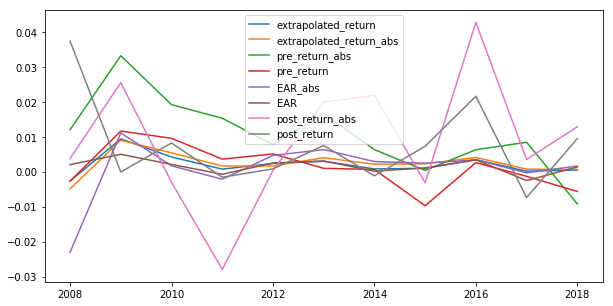

In [279]:
average_return_by_year.plot(figsize=[10,5])

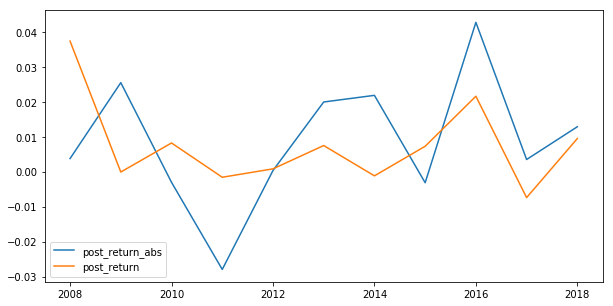

In [439]:
average_return_by_year[["post_return_abs","post_return"]].plot(figsize=[10,5])

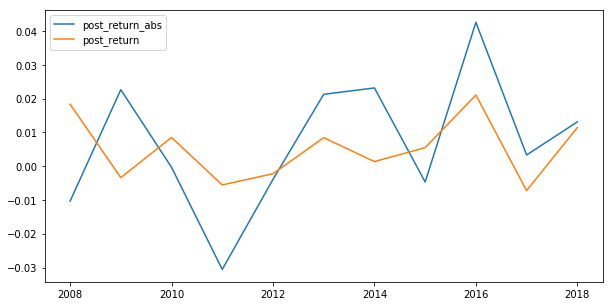

In [298]:
average_return_high_extrapolated[["post_return_abs","post_return"]].plot(figsize=[10,5])

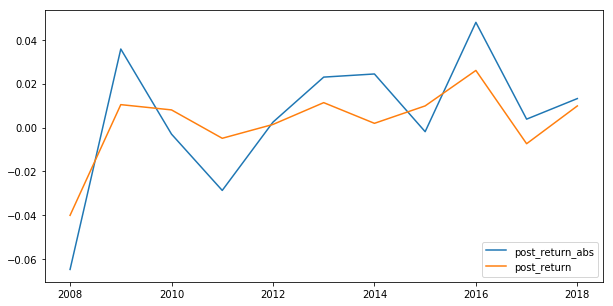

In [299]:
average_return_low_extrapolated[["post_return_abs","post_return"]].plot(figsize=[10,5])

# 5. Announcement premium

In [376]:
return_month=rel_return_US.apply(lambda x:pd.Timestamp(datetime.strptime(x.name,"%d/%b/%Y").year,\
                                                       datetime.strptime(x.name,"%d/%b/%Y").month,\
                                                       1),axis=0)

In [379]:
fundamental_month=target_US.apply(lambda x:pd.Timestamp(datetime.strptime(x["Date"],"%d/%b/%Y").year,\
                                  datetime.strptime(x["Date"],"%d/%b/%Y").month,\
                                  1),axis=1)

In [386]:
month_dict={}
for i in sorted(fundamental_month.unique()):
    target_df=rel_return_US.loc[target_US[fundamental_month==i].\
                                apply(lambda x:x.name[0],axis=1),return_month==i]
    target_df.index=target_US[fundamental_month==i].index
    target_df.columns=list(range(1,target_df.shape[1]+1))
    month_dict[i]=target_df

In [392]:
i=fundamental_month.unique()[10]

In [403]:
month_return_dict={}
for i in month_dict.keys():
    month_return_dict[i]=((1+month_dict[i]).cumprod(axis=1).iloc[:,-1]-1).sort_values().mean()

In [425]:
pd.Series(month_return_dict).mean()

0.008007687558930271

In [419]:
(pd.Series(month_return_dict).std())/(np.sqrt(pd.Series(month_return_dict).shape[0]))

0.0019567951966642377

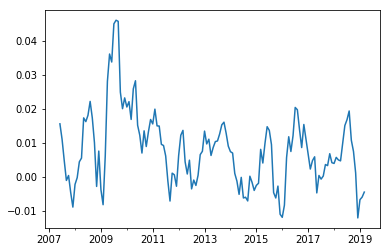

In [423]:
pd.Series(month_return_dict).rolling(6).mean().plot()

# 4. Signal class 

In [799]:
class signal(object):
    '''
    Signal class is built to initialize the signal_df and account curve from base parameters 
    '''
    def __init__(self,fundamental_df,price_df,EAR_period,entry,long_criteria,short_criteria,holding,start,end,old_position\
                 ,new_signal,revision_adjust,early_exit):
        '''
        Define the key free parameters of the signal
        Criteria:(EAR,revision,revision_norm,size)
        revision_adjust:(True/False,(long lower revision,long higher revision),(short low abs revision,short high abs_revision)\
        ,size_multiple)
        '''
        self.fundamental_df=fundamental_df
        self.price_df=price_df
        self.abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
        self.EAR_period=EAR_period
        self.entry=entry
        self.long_criteria=long_criteria
        self.short_criteria=short_criteria
        self.holding=holding
        self.start=start
        self.end=end
        self.old_position=old_position
        self.new_signal=new_signal
        self.revision_adjust=revision_adjust #(True/False,lower_revision,higher_revision in absolute terms,size_multiple)
        self.early_exit=early_exit
        
    def signal_base(self):
        '''
        Filter the signal criteria like EAR and rperioevision, get the target signal list
        From the fundamental information
        For both long and short side
        '''
        
        long_base=self.fundamental_df.copy()
        short_base=self.fundamental_df.copy()
        

        long_base["EAR"]=long_base.apply(lambda x:EAR_calc(x.name[0],x.name[1],self.abs_return,self.EAR_period,30)\
                                     if x.name[0] in self.abs_return.index else None,axis=1)

        short_base["EAR"]=short_base.apply(lambda x:EAR_calc(x.name[0],x.name[1],self.abs_return,self.EAR_period,30)\
                                     if x.name[0] in self.abs_return.index else None,axis=1)


        if self.long_criteria is None:
            long_base=None
        else:
            
            if self.long_criteria[1] is None:
                pass
            else:
                if self.new_signal is True:
                    long_base=long_base[(long_base["Revision_real"]>self.long_criteria[1][0])\
                                                    &(long_base["Revision_real"]<self.long_criteria[1][1])]
                else:
                    long_base=long_base[(long_base["Revision_20"]>self.long_criteria[1][0])\
                                                    &(long_base["Revision_20"]<self.long_criteria[1][1])]                    

            if self.long_criteria[2] is None:
                pass
            else:
                long_base=long_base[(long_base["Revision_norm"]>self.long_criteria[2][0])\
                                                    &(long_base["Revision_norm"]<self.long_criteria[2][1])]
                
            if self.long_criteria[3] is None:
                pass
            else:
                long_base=long_base[(long_base["Market cap"]>self.long_criteria[3][0])&\
                                        (long_base["Market cap"]<self.long_criteria[3][1])]
            
            if self.long_criteria[0] is None:
                pass
            else:
                long_base=long_base[(long_base["EAR"]>self.long_criteria[0][0])&(long_base["EAR"]<self.long_criteria[0][1])]
                
                
        if self.short_criteria is None:
            short_base=None
        else:
            
            if self.short_criteria[1] is None:
                pass
            else:
                if self.new_signal is True:
                    short_base=short_base[(short_base["Revision_real"]>self.short_criteria[1][0])\
                                                    &(short_base["Revision_real"]<self.short_criteria[1][1])]
                else:
                    short_base=short_base[(short_base["Revision_20"]>self.short_criteria[1][0])\
                                                    &(short_base["Revision_20"]<self.short_criteria[1][1])]                    

            if self.short_criteria[2] is None:
                pass
            else:
                short_base=short_base[(short_base["Revision_norm"]>self.short_criteria[2][0])\
                                                    &(short_base["Revision_norm"]<self.short_criteria[2][1])]
                
            if self.short_criteria[3] is None:
                pass
            else:
                short_base=short_base[(short_base["Market cap"]>self.short_criteria[3][0])&\
                                        (short_base["Market cap"]<self.short_criteria[3][1])]
            
            if self.short_criteria[0] is None:
                pass
            else:
                short_base=short_base[(short_base["EAR"]>self.short_criteria[0][0])&\
                                      (short_base["EAR"]<self.short_criteria[0][1])]
        
        self.long_base=long_base
        self.short_base=short_base
        
        return long_base,short_base
    
    def signal_df_date(self):#if we hold them through next earning
        '''
        Obtain the signal_df function over the whole time period from the target signal list
        '''
        try:
            long_base=self.long_base.copy()
            short_base=self.short_base.copy()
        except:
            long_base,short_base=signal.signal_base(self)
        
        if long_base is None:
            long_df=None
        
        else:
            long_df=pd.DataFrame(index=self.price_df.columns)

            for s in long_base.index:
                return_series=self.abs_return.loc[s[0]]
                if s[1] in return_series.index:
                    if not np.isnan(return_series.loc[s[1]]): 
                        day0=return_series.index.tolist().index(s[1])
                        
                        if self.early_exit is True and datetime.strptime(s[1],"%d/%b/%Y").date()>=\
                        datetime.strptime(s[3],"%d/%b/%Y").date():
                            period=None
                        
                        elif self.early_exit is True and type(s[2])!=float and datetime.strptime(s[1],"%d/%b/%Y").date()<\
                        datetime.strptime(s[3],"%d/%b/%Y").date():
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y").date(),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y").date())-self.entry,
                                      np.busday_count(datetime.strptime(s[1],"%d/%b/%Y").date(),\
                                                                    datetime.strptime(s[3],"%d/%b/%Y").date())-self.entry+1)                            
                        
                        elif self.early_exit is True and type(s[2])==float and datetime.strptime(s[1],"%d/%b/%Y").date()<\
                        datetime.strptime(s[3],"%d/%b/%Y").date():
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y").date(),\
                                                                    datetime.strptime(s[3],"%d/%b/%Y").date())-self.entry+1)
                            
                        elif type(s[2])==float:##basically np.nan has type float
                            period=self.holding+1
                        
                        else: ##assume that we are not holding through numbers
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y").date(),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y").date())-self.entry)
                            
                        if period is None:
                            pass
                        else:
                            target_series=return_series.iloc[day0+self.entry-1:day0+min(period+self.entry, \
                                                                                           len(return_series[day0:]))].dropna()
                            
                            if len(target_series)==0:
                                pass
                            else:
                                target_series.iloc[0]=0.0
                                long_df[s]=target_series                        

                    else:
                        pass
                else:
                    pass
                
            long_df=long_df.reindex(datetime.strptime(i,"%d/%b/%Y") for i in long_df.index)
            long_df=long_df.sort_index()

            if self.start is not None:
                long_df=slice_universe(long_df,self.start,self.end,self.old_position)
            else:
                pass
            
            long_df=long_df.dropna(how="all",axis=1)
            #long_df.columns=pd.MultiIndex.from_tuples(pd.Series(list(long_df.columns)))
            self.long_df=long_df
            
            
        
        if short_base is None:
            short_df=None
        
        else:
            short_df=pd.DataFrame(index=self.price_df.columns)

            for s in short_base.index:
                return_series=self.abs_return.loc[s[0]]
                if s[1] in return_series.index:
                    if not np.isnan(return_series.loc[s[1]]): 
                        day0=return_series.index.tolist().index(s[1])
                        
                        if self.early_exit is True and datetime.strptime(s[1],"%d/%b/%Y").date()>=\
                        datetime.strptime(s[3],"%d/%b/%Y").date():
                            period=None
                            
                        elif self.early_exit is True and type(s[2])!=float and datetime.strptime(s[1],"%d/%b/%Y").date()<\
                        datetime.strptime(s[3],"%d/%b/%Y").date():
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y").date(),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y").date())-self.entry,
                                      np.busday_count(datetime.strptime(s[1],"%d/%b/%Y").date(),\
                                                                    datetime.strptime(s[3],"%d/%b/%Y").date())-self.entry+1)  
                            
                        elif self.early_exit is True and type(s[2])==float and datetime.strptime(s[1],"%d/%b/%Y").date()<\
                        datetime.strptime(s[3],"%d/%b/%Y").date():
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y").date(),\
                                                                    datetime.strptime(s[3],"%d/%b/%Y").date())-self.entry+1)
                        elif type(s[2])==float:##basically np.nan has type float
                            period=self.holding
                    
                        else: ##assume that we are not holding through numbers
                            period=min(self.holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y").date(),\
                                                                    datetime.strptime(s[2],"%d/%b/%Y").date())-self.entry)\


                        if period is None:
                            pass
                        else:
                            target_series=return_series.iloc[day0+self.entry-1:day0+min(period+self.entry, \
                                                                                           len(return_series[day0:]))].dropna()
                            
                            if len(target_series)==0:
                                pass
                            else:
                                target_series.iloc[0]=0.0
                                short_df[s]=target_series         
                            
                    else:
                        pass
                else:
                    pass

            short_df=short_df.reindex(datetime.strptime(i,"%d/%b/%Y") for i in short_df.index)
            short_df=short_df.sort_index()

            if self.start is not None:
                short_df=slice_universe(short_df,self.start,self.end,self.old_position)
            else:
                pass  
            
            short_df=short_df.dropna(how="all",axis=1)
            #short_df.columns=pd.MultiIndex.from_tuples(pd.Series(list(short_df.columns)))
            self.short_df=short_df
        
        return long_df,short_df

    def signal_account(self,stop,gross,index_df,net_level,risk_parity,liquidity,capital):
        '''
        Build the account curve with signal_df
        Assume quarterly rebalancing that's why the period list has quarter as the key
        Take extra care when building the account curve, the logic is: work out the size_df, then shift by 1 and * signal_df
        Stop=(long_stop,short_stop,type)
        index_df has to be a dataframe with a name
        '''
        
        try:
            long_df=self.long_df.copy()
            short_df=self.short_df.copy()
            
        except:
            long_df,short_df=self.signal_df_date()
                   
        '''
        Assign values for later use
        '''
        
        self.capital=capital
        
        self.index_df=index_df
        self.index_df.index=[datetime.strptime(i,"%d/%b/%Y") for i in self.index_df.index]
       
        
        '''
        Define rebalance period first
        '''
        if long_df is None:
            period_quarter=short_df.apply(lambda x:str(x.name.year)+" "+str(x.name.quarter),axis=1)
            period_list=list(set(period_quarter))
            period_list.sort()    
            
        else:
            period_quarter=long_df.apply(lambda x:str(x.name.year)+" "+str(x.name.quarter),axis=1)
            period_list=list(set(period_quarter))
            period_list.sort()    
                
        '''
        Separate out long and short
        '''
        if long_df is None:
            long_cache=(None,None,None,None)
        else:
            if stop is None:
                pass
            else:
                long_df=signal_filter_stop(long_df,stop[0],self.abs_return,30,stop[2],self.index_df)   
                self.long_df=long_df

            long_sub_signal={}
            long_sub_size_row={}
            long_sub_size_df={}
            long_sub_pnl={}
        
            for s in period_list:
            
                long_sub_signal[s]=long_df[period_quarter==s].dropna(how='all',axis=1)
                
                if long_sub_signal[s].shape[1]==0:
                    long_sub_size_df[s]=long_sub_signal[s]
                    long_sub_pnl[s]=long_sub_signal[s]
                    
                else:
                    if period_list.index(s)<4:##use last quarter's sizing as reference
                        long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[s],gross[0],self.fundamental_df,\
                                                       self.new_signal,self.abs_return,risk_parity,liquidity,capital,\
                                                    self.revision_adjust,True)[0]
                    else:
                        try:
                            long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[period_list[period_list.index(s)-1]],\
                                                       gross[0],self.fundamental_df,self.new_signal,self.abs_return,\
                                                        risk_parity,liquidity,capital,self.revision_adjust,True)[0]
                        except:
                            long_sub_size_row[s]=sizing(long_sub_signal[s],long_sub_signal[s],\
                                                       gross[0],self.fundamental_df,self.new_signal,self.abs_return,\
                                                        risk_parity,liquidity,capital,self.revision_adjust,True)[0] 

                    long_sub_size_df[s]=(1+long_sub_signal[s]).cumprod()*long_sub_size_row[s]
                    long_sub_pnl[s]=(long_sub_size_df[s].shift(1))*long_sub_signal[s] 
                    # need to shift by 1 as the size is end of the day
        
            long_daily_pnl=pd.concat(list(long_sub_pnl.values()),axis=0)
            long_acct_curve=long_daily_pnl.cumsum().ffill().sum(axis=1)
            long_size_df=pd.concat(list(long_sub_size_df.values()),axis=0)
            long_ind_return=long_daily_pnl.cumsum().ffill().iloc[-1].dropna()
            long_cache=(long_daily_pnl,long_acct_curve,long_size_df,long_ind_return)
            
            self.long_cache=long_cache

            
        if short_df is None:
            short_cache=(None,None,None,None)
        else:
            if stop is None:
                pass
            else:
                short_df=-signal_filter_stop(-short_df,stop[1],self.abs_return,30,stop[2],self.index_df)   
                self.short_df=short_df

            short_sub_signal={}
            short_sub_size_row={}
            short_sub_size_df={}
            short_sub_pnl={}
        
            for s in period_list:
                short_sub_signal[s]=short_df[period_quarter==s].dropna(how='all',axis=1)

                if short_sub_signal[s].shape[1]==0:
                    short_sub_size_df[s]=short_sub_signal[s]
                    short_sub_pnl[s]=short_sub_signal[s]
                    
                else:
                    
                    if period_list.index(s)<4:##use last quarter's sizing as reference
                        short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal[s],gross[1],self.fundamental_df,\
                                                       self.new_signal,self.abs_return,risk_parity,liquidity,capital,\
                                                      self.revision_adjust,False)[0]
                    else:
                        try:
                            short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal\
                                                          [period_list[period_list.index(s)-1]],\
                                                           gross[1],self.fundamental_df,self.new_signal,self.abs_return,\
                                                          risk_parity,liquidity,\
                                                          capital,self.revision_adjust,False)[0]
                        except:
                            short_sub_size_row[s]=-sizing(short_sub_signal[s],short_sub_signal[s],\
                                                           gross[1],self.fundamental_df,self.new_signal,self.abs_return,\
                                                          risk_parity,liquidity,\
                                                          capital,self.revision_adjust,False)[0]

                    short_sub_size_df[s]=(1+short_sub_signal[s]).cumprod()*short_sub_size_row[s]
                    short_sub_pnl[s]=(short_sub_size_df[s].shift(1))*short_sub_signal[s] 
                # need to shift by 1 as the size is end of the day
        
            short_daily_pnl=pd.concat(list(short_sub_pnl.values()),axis=0)
            short_acct_curve=short_daily_pnl.cumsum().ffill().sum(axis=1)
            short_size_df=pd.concat(list(short_sub_size_df.values()),axis=0)
            short_ind_return=short_daily_pnl.cumsum().ffill().iloc[-1].dropna()
            
            short_cache=(short_daily_pnl,short_acct_curve,short_size_df,short_ind_return)
            self.short_cache=short_cache
    
        '''Put alpha positions together to form the alpha part'''
        alpha_df=pd.concat([long_df,short_df],axis=1)
        self.alpha_df=alpha_df
        
        alpha_daily_pnl=pd.concat([long_cache[0],short_cache[0]],axis=1)
        alpha_acct_curve=alpha_daily_pnl.cumsum().ffill().sum(axis=1)
        alpha_size_df=pd.concat([long_cache[2],short_cache[2]],axis=1)
        alpha_ind_return=pd.concat([long_cache[3],short_cache[3]],axis=0)
        
        alpha_cache=(alpha_daily_pnl,alpha_acct_curve,alpha_size_df,alpha_ind_return)
        
        
        if self.index_df is not None:
            if self.index_df.shape[1]==1:
                index_df=self.index_df.copy().loc[alpha_df.index] 
                index_size_df=(net_level-alpha_size_df.sum(axis=1)).to_frame(index_df.columns[0])
                index_daily_pnl=index_size_df.shift(1)*index_df
                index_acct_curve=index_daily_pnl.cumsum()
                index_ind_return=index_acct_curve.iloc[-1]
                index_cache=(index_daily_pnl,index_acct_curve,index_size_df,index_ind_return)
            else:
                index_df=self.index_df.copy().loc[alpha_df.index] 
                alpha_temp=alpha_cache[2].copy().T
                alpha_temp["index"]=alpha_temp.apply(lambda x:Asia_mapping.loc[x.name[0][-2:]].iloc[0],axis=1)
                index_size_df=net_level-alpha_temp.groupby("index").apply(sum).T.iloc[:-1]
                index_daily_pnl=index_size_df.shift(1)*index_df
                index_acct_curve=index_daily_pnl.cumsum()
                index_ind_return=index_acct_curve.iloc[-1]
                index_cache=(index_daily_pnl,index_acct_curve,index_size_df,index_ind_return)
        else:
            index_cache=(None,None,None,None)
            
        '''Finally put everything together'''    
        portfolio_df=pd.concat([alpha_df,index_df],axis=1)
            
        portfolio_size_df=pd.concat([alpha_cache[2],index_cache[2]],axis=1).sort_index()
  
        portfolio_daily_pnl=pd.concat([alpha_cache[0],index_cache[0]],axis=1).sort_index()

        portfolio_acct_curve=portfolio_daily_pnl.cumsum().ffill().sum(axis=1)
        portfolio_ind_return=alpha_cache[3].copy()
        
        portfolio_gross=np.abs(portfolio_size_df).sum(axis=1).sort_index()
        portfolio_turnover=(np.abs(alpha_size_df.fillna(0.0).diff(1)).sum().sum())/(portfolio_size_df.shape[0]/260)
        
        portfolio_cache=(portfolio_daily_pnl,portfolio_acct_curve,portfolio_size_df,portfolio_ind_return,portfolio_gross,\
                         portfolio_turnover,portfolio_df)
        
        self.portfolio_account=portfolio_cache #save for later use
        
        
        return long_cache,short_cache,alpha_cache,portfolio_cache
    
    def plot_account(self,title,figsize=[10,4],portfolio=None):
        '''
        Plot the account curve
        '''
        if portfolio is None:
            try:
                portfolio_cache=self.portfolio_account

            except AttributeError:
                print("Execute the signal_account first!")  
                return None
        else:
            portfolio_cache=portfolio
        
        plot_signal(title,figsize,portfolio_cache)




In [ ]:
def combine_signal(portfolio_list,capital_list):
    
    
    daily_pnl_list=[]
    signal_df_list=[]
    portfolio_size_list=[]
    for i in range(len(portfolio_list)):

        daily_pnl_list.append(portfolio_list[i][0]*capital_list[i]/np.sum(capital_list))
        signal_df_list.append(portfolio_list[i][-1]*capital_list[i]/np.sum(capital_list))
        portfolio_size_list.append(portfolio_list[i][2]*capital_list[i]/np.sum(capital_list))
    
    daily_pnl=pd.concat(daily_pnl_list,axis=1)
    signal_df=pd.concat(signal_df_list,axis=1)
    size_df=pd.concat(portfolio_size_list,axis=1)
    
    account_curve=daily_pnl.cumsum().ffill().sum(axis=1)
    ind_return=daily_pnl.cumsum().ffill().iloc[-1]

    gross=np.abs(size_df).sum(axis=1)
    turnover=(np.abs(size_df.fillna(0.0).diff(1)).sum().sum())/(size_df.shape[0]/260)
    
    portfolio_cache=(daily_pnl,account_curve,size_df,ind_return,gross,turnover,signal_df)
    return portfolio_cache

In [ ]:
def sharpe_by_year(account_curve,year_list):
    result_dict={}
    for i in year_list:
        sub_curve=account_curve.iloc[(account_curve.index>=pd.Timestamp(i,1,1))&(account_curve.index<=pd.Timestamp(i,12,31))]
        result_dict[i]=trading_analytics_simp(sub_curve)[0]
    return result_dict

In [ ]:
def dd_by_year(account_curve,year_list):
    result_dict={}
    for i in year_list:
        sub_curve=account_curve.iloc[(account_curve.index>=pd.Timestamp(i,1,1))&(account_curve.index<=pd.Timestamp(i,12,31))]
        result_dict[i]=trading_analytics_simp(sub_curve)[1]
    return result_dict

# 5 - Result

## 5.1-Europe

In [ ]:
Europe_new=signal(fundamental_df=Europe2_old,
                   price_df=Europe_VWAP,
                   EAR_period=1,
                   entry=3,
                   long_criteria=((2,1000),(0.02,1000),None,None),
                   short_criteria=((-1000,-2),(-1000,-0.02),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2010,1,1),
                   end=pd.Timestamp(2019,3,29),
                   old_position=False,
                   new_signal=True,
                   revision_adjust=(True,(0.02,0.05),(-0.05,-0.02),2),
                  early_exit=False)

In [ ]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Europe_new.signal_account(stop=[9,12,"rel"],
                                                           gross=(26,13),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=60)

In [ ]:
plot_signal("Europe new signal - no stop",[10,4],Europe_new.portfolio_account)

In [ ]:
plot_signal("Europe new signal - 100k abs stop",[10,4],Europe_new.portfolio_account)

In [ ]:
plot_signal("Europe new signal - 200k abs stop",[10,4],Europe_new.portfolio_account)

In [ ]:
plot_signal("Europe new signal - 100k rel stop",[10,4],Europe_new.portfolio_account)

In [ ]:
plot_signal("Europe new signal - 200k rel stop",[10,4],Europe_new.portfolio_account)

In [ ]:
Europe_orig=signal(fundamental_df=Europe2_old,
                    price_df=Europe_price,
                    EAR_period=1,
                    entry=2,
                    long_criteria=((1,1000),(0.03,1000),None,None),
                    short_criteria=((-1000,-2),(-1000,-0.03),None,(5000,10000000)),
                    holding=30,
                    start=pd.Timestamp(2010,1,1),
                    end=pd.Timestamp(2019,3,29),
                    old_position=False,
                    new_signal=False,
                    revision_adjust=(False,0.02,0.1,2),
                    early_exit=False)

In [ ]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Europe_orig.signal_account(stop=[4.5,6,"rel"],
                                                           gross=(25,13),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=60)

In [ ]:
plot_signal("Europe orig signal - no stop",[10,4],Europe_orig.portfolio_account)

In [ ]:
plot_signal("Europe orig signal - abs stop 100k",[10,4],Europe_orig.portfolio_account)

In [ ]:
plot_signal("Europe orig signal - abs stop 200k",[10,4],Europe_orig.portfolio_account)

In [ ]:
plot_signal("Europe orig signal - rel stop 100k",[10,4],Europe_orig.portfolio_account)

In [ ]:
plot_signal("Europe orig signal - rel stop 200k",[10,4],Europe_orig.portfolio_account)

## 5.2 - Asia

In [ ]:
Asia_new=signal(fundamental_df=Asia2_old,
                price_df=Asia_VWAP,
                EAR_period=2,
                entry=3,
                long_criteria=((1,1000),(0.02,1000),None,None),
                short_criteria=None,
                holding=20,
                start=pd.Timestamp(2010,1,1),
                end=pd.Timestamp(2019,3,29),
                old_position=False,
                new_signal=True,
                revision_adjust=(True,(0.02,0.05),(-0.1,-0.02),2),
                early_exit=False)

In [ ]:
_long_Asia,_short_Asia,_alpha_Asia,_portfolio_Asia=Asia_new.signal_account(stop=[5.5,None,'rel'],
                                                           gross=(28,None),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=40)

In [ ]:
Asia_new.plot_account("Asia new signal - no stop")

In [ ]:
Asia_new.plot_account("Asia new signal - 100k abs stop")

In [ ]:
Asia_new.plot_account("Asia new signal - 200k abs stop")

In [ ]:
Asia_new.plot_account("Asia new signal - 100k rel stop")

In [ ]:
Asia_new.plot_account("Asia new signal - 200k rel stop")

In [ ]:
Asia_orig=signal(fundamental_df=Asia2_old,
                 price_df=Asia_price,
                 EAR_period=2,
                 entry=2,
                 long_criteria=((2,1000),(0.02,1000),None,None),
                 short_criteria=None,
                 holding=20,
                 start=pd.Timestamp(2010,1,1),
                 end=pd.Timestamp(2019,3,29),
                 old_position=False,
                 new_signal=False,
                 revision_adjust=(False,(0.02,0.1),(-0.1,-0.02),3),
                 early_exit=False)

In [ ]:
_long_Asia,_short_Asia,_alpha_Asia,_portfolio_Asia=Asia_orig.signal_account(stop=[16,None,'rel'],
                                                           gross=(29,None),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=40)

In [ ]:
Asia_orig.plot_account("Asia orig signal - no stop")

In [ ]:
Asia_orig.plot_account("Asia orig signal - 100k abs stop")

In [ ]:
Asia_orig.plot_account("Asia orig signal - 200k abs stop")

In [ ]:
Asia_orig.plot_account("Asia orig signal - 100k rel stop")

In [ ]:
Asia_orig.plot_account("Asia orig signal - 200k rel stop")

## 5.3 - US

In [ ]:
US_new=signal(fundamental_df=US1_old,
               price_df=US_VWAP,
               EAR_period=1,
               entry=2,
               long_criteria=((2,1000),(0.05,1000),None,None),
               short_criteria=((-1000,-2),(-1000,-0.03),None,(5000,10000000)),
               holding=30,
               start=pd.Timestamp(2010,1,1),
               end=pd.Timestamp(2019,3,29),
               old_position=False,
               new_signal=True,
               revision_adjust=(True,(0.05,0.1),(-0.1,-0.03),2),
               early_exit=False)

In [ ]:
_long,_short,_alpha,_portfolio=US_new.signal_account(stop=[20,18,"rel"],
                                                           gross=(30,15),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=65)

In [ ]:
plot_signal("US new signal - no stop",[10,4],US_new.portfolio_account)

In [ ]:
plot_signal("US new signal - abs stop 100k",[10,4],US_new.portfolio_account)

In [ ]:
plot_signal("US new signal - abs stop 200k",[10,4],US_new.portfolio_account)

In [ ]:
plot_signal("US new signal - rel stop 100k",[10,4],US_new.portfolio_account)

In [ ]:
plot_signal("US new signal - rel stop 200k",[10,4],US_new.portfolio_account)

In [ ]:
US_orig=signal(fundamental_df=US1_old,
                price_df=US_price,
                EAR_period=1,
                entry=2,
                long_criteria=((3,1000),(0.05,1000),None,None),
                short_criteria=((-1000,-2),(-1000,-0.03),None,(5000,10000000)),
                holding=30,
                start=pd.Timestamp(2010,1,1),
                end=pd.Timestamp(2019,3,29),
                old_position=False,
                new_signal=False,
                revision_adjust=(False,(0.05,0.2),(-0.1,-0.03),2),
               early_exit=False)

In [ ]:
_long,_short,_alpha,_portfolio=US_orig.signal_account(stop=None,
                                                           gross=(26,15),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=65)

In [ ]:
plot_signal("US orig signal - no exit",[10,4],US_orig.portfolio_account)

# 6 - Fitting choice

In [ ]:
def fitting_df(long,EAR_list,revision_list,fundamental_df,price_df,EAR_period,holding,start,end,stop,gross,index_df,
               net_level,risk_parity,liquidity,capital,exclusive,old_position,new_signal):
    '''
    Create a dataframe of sharpe and drawdown for different fitting variations
    EAR/revision list includes the upper bound
    Exclusive means gap and non eclusive means from that to the maximum
    '''
    year_list=range(start.year,end.year+1)
    EAR_list.sort()
    revision_list.sort()
    
    criteria_list_short=list(itertools.product(*[EAR_list[1:],revision_list[1:]]))
    criteria_list_long=list(itertools.product(*[EAR_list[:-1],revision_list[:-1]]))
    
    sharpe_dict={}
    dd_dict={}
    if exclusive:
        if long:
            for s in criteria_list_long:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=((s[0],EAR_list[EAR_list.index(s[0])+1]),\
                                                  (s[1],revision_list[revision_list.index(s[1])+1]),None,None),
                                   short_criteria=None,
                                   holding=holding,
                                   start=start,
                                   end=end,
                                   old_position=old_position,
                                   new_signal=new_signal)
                
                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[s]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[s]=dd_by_year(portfolio[-1][1],year_list)
                
        else:
            for s in criteria_list_short:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=None,
                                   short_criteria=((EAR_list[EAR_list.index(s[0])-1],s[0]),\
                                                   (revision_list[revision_list.index(s[1])-1],s[1]),None,(5000,10000000)),
                                   holding=holding,
                                   start=start,
                                   end=end,
                                   old_position=old_position,
                                   new_signal=new_signal)

                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[s]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[s]=dd_by_year(portfolio[-1][1],year_list)
    
    else:
        if long:
            for i in criteria_list_long:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=((i[0],10),(i[1],10),None,None),
                                   short_criteria=None,
                                   holding=holding,
                                   start=start,
                                   end=end,
                                   old_position=old_position,
                                   new_signal=new_signal)

                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[i]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[i]=dd_by_year(portfolio[-1][1],year_list)
                
        else:
            for i in criteria_list_short:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=None,
                                   short_criteria=((-10,i[0]),(-10,i[1]),None,(5000,10000000)),
                                   holding=holding,
                                   start=start,
                                   end=end,
                                   old_position=old_position,
                                   new_signal=new_signal)
                
                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[i]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[i]=dd_by_year(portfolio[-1][1],year_list)

    sharpe_df=pd.DataFrame(sharpe_dict)
    dd_df=pd.DataFrame(dd_dict)
        
    return sharpe_df,dd_df
        

In [ ]:
Europe_long_sharpe,Europe_long_dd=fitting_df(True,[1,2,3,4],[0.02,0.03,0.04,0.05,10],Europe2,Europe_price,2,30,\
                                             pd.Timestamp(2010,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),0,True,0.2,50,True,
                                            False,False)

In [ ]:
Europe_long_sharpe

In [ ]:
Europe_short_sharpe,Europe_short_dd=fitting_df(False,[-1,-2,-3,-4],[-0.02,-0.03,-0.04,-0.05,-0.06],Europe,Europe_price,2,30,\
                                             pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,8),(30,30)\
                                             ,abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),0,True,0.2,50)

In [ ]:
Europe_short_sharpe.to_csv("Europe_short_sharpe.csv")

In [ ]:
Europe_short_dd.to_csv("Europe_short_dd.csv")

In [ ]:
US_long_sharpe,US_long_dd=fitting_df(True,[1,2,3,4],[0.02,0.03,0.04,0.05,0.06,0.07],\
                                     US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50)

In [ ]:
adj_US_long_sharpe,adj_US_long_dd=fitting_df(True,[1,2,3,4],[0.02,0.03,0.04,0.05,0.06,0.07],\
                                     adj_US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50,False)

In [ ]:
US_short_sharpe,US_short_dd=fitting_df(False,[-1,-2,-3,-4],[-0.02,-0.03,-0.04,-0.05,-0.06,-0.07],\
                                     US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,8),(30,30)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50)

In [ ]:
adj_US_short_sharpe,adj_US_short_dd=fitting_df(False,[-1,-2,-3],[-0.02,-0.03,-0.04,-0.05],\
                                     adj_US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,8),(30,30)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50,False)

In [ ]:
US_short_sharpe.to_csv("US_short_sharpe.csv")

In [ ]:
US_short_dd.to_csv("US_short_dd.csv")

In [ ]:
Asia_long_sharpe,Asia_long_dd=fitting_df(True,[1,2,3,4],[0.02,0.03,0.04,0.05,0.06,0.07],\
                                     Asia,Asia_price,2,20,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T\
                                     ,0,True,0.2,50)

In [ ]:
Asia_long_sharpe.to_csv("Asian_long_sharpe.csv")

In [ ]:
Asia_long_dd.to_csv("Asian_long_dd.csv")

# 7 - Drawdown analysis

In [ ]:
def drawdown_days(acct_curve,timestamp):
    dd=acct_curve-acct_curve.cummax()
    previous_high=acct_curve.loc[:timestamp].max()
    high_timestamp=acct_curve[acct_curve==previous_high].index[0]
    days=acct_curve.index.tolist().index(timestamp)-acct_curve.index.tolist().index(high_timestamp)
    return (high_timestamp,days)

In [ ]:
def drawdown_df(portfolio_cache):
    drawdown=portfolio_cache[-1].iloc[:,-1].to_frame()
    drawdown.columns=["Index"]
    drawdown["Index vol"]=drawdown["Index"].rolling(30).std()
    drawdown["Portfolio"]=portfolio_cache[1].diff(1)
    drawdown["Account"]=portfolio_cache[1].copy()
    drawdown["Drawdown"]= drawdown["Account"]- drawdown["Account"].cummax()
    drawdown["Drawdown days"]= drawdown.apply(lambda x: drawdown_days(drawdown["Account"],x.name)[1],axis=1)
    drawdown["Drawdown start"]= drawdown.apply(lambda x: drawdown_days(drawdown["Account"],x.name)[0],axis=1)
    drawdown["Gross"]=np.abs(portfolio_cache[2]).sum(axis=1)
    return drawdown
    

In [ ]:
def portfolio_drawdown_df(portfolio_cache,stop,multiple):
    portfolio_cache_list=list(portfolio_cache)
    orig_size=portfolio_cache_list[2]
    orig_account=portfolio_cache_list[1]
    dd=orig_account-orig_account.cummax()
    stop_evaluate=dd[dd.shift(1)<stop]
    adj_size=orig_size.apply(lambda x: x*multiple if x.name in stop_evaluate.index else x,axis=1)
    
    new_portfolio_cache=portfolio_cache_list.copy()
    new_portfolio_cache[2]=adj_size
    new_portfolio_cache[0]=adj_size.shift(1)*new_portfolio_cache[-1]
    new_portfolio_cache[1]=new_portfolio_cache[0].sum(axis=1).cumsum()
    return tuple(new_portfolio_cache)
    

# 8- Quarterly review

In [ ]:
def review_df(signal_class,start,end,old_position):
    '''
    dataframe for review purpose
    '''
    try:
        long_abs_return=slice_universe(signal_class.long_df.copy(),start,end,old_position)
        long_abs_return[long_abs_return==0]=None
        long_rel_return=long_abs_return.subtract(signal_class.portfolio_account[-1].iloc[:,-1],axis=0)
        long_df=((1+long_rel_return).cumprod()-1).ffill().iloc[-1].to_frame()
        long_df["Ticker"]=long_df.apply(lambda x:x.name[0],axis=1)
        long_df["Date"]=long_df.apply(lambda x:datetime.strptime(x.name[1],"%d/%b/%Y"),axis=1)
        
        long_size=slice_universe(signal_class.long_cache[2].copy(),start,end,old_position)
        long_df["Size"]=long_size.apply(lambda x: x.dropna().iloc[0],axis=0)
    except:
        long_df=None

    try:
        short_abs_return=-slice_universe(signal_class.short_df.copy(),start,end,old_position)
        short_abs_return[short_abs_return==0]=None
        short_rel_return=short_abs_return.add(signal_class.portfolio_account[-1].iloc[:,-1],axis=0)
        short_df=((1+short_rel_return).cumprod()-1).ffill().iloc[-1].to_frame()
        short_df["Ticker"]=short_df.apply(lambda x:x.name[0],axis=1)
        short_df["Date"]=short_df.apply(lambda x:datetime.strptime(x.name[1],"%d/%b/%Y"),axis=1)
        
        short_size=slice_universe(signal_class.short_cache[2].copy(),start,end,old_position)
        short_df["Size"]=short_size.apply(lambda x: x.dropna().iloc[0],axis=0)
    except:
        short_df=None
        
    return long_df,short_df

In [ ]:
Asia_long,Asia_short=review_df(Asia_fit1,pd.Timestamp(2019,1,1),pd.Timestamp(2019,3,29),False)

In [ ]:
Asia_long.to_csv("Asia_long.csv")

# 9 - Sizing for the live trading

## 9.2 -  US live sizing

In [ ]:
US_live_orig=signal(fundamental_df=US2,
                   price_df=US_price,
                   EAR_period=1,
               entry=2,
                   long_criteria=((3,1000),(0.05,1000),None,None),
                   short_criteria=((-1000,-2),(-1000,-0.03),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,29),
                  old_position=False,
                  new_signal=False,
                 revision_adjust=(False,(0.05,0.2),(-0.1,-0.03),2))

In [ ]:
_long_US_live,_short_US_live,_alpha_US_live,_portfolio_US_live=US_live_orig.signal_account(stop=(8,8),
                                                           gross=(30,15),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=65)

In [ ]:
US_live.plot_account("US reference")

In [ ]:
'''
US reference sizing and volatility
'''
print("US long size is "+str(_long_US_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("US long volatility is "+str(US2.loc[_long_US_live[-1].index]["30d_vol"].mean()))
print("US long number is "+str(_long_US_live[2].count(axis=1).mean()))
print("US short size is "+str(_short_US_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("US short volatility is "+str(US2.loc[_short_US_live[-1].index]["30d_vol"].mean()))
print("US short number is "+str(_short_US_live[2].count(axis=1).mean()))

In [ ]:
US_live_new=signal(fundamental_df=US1,
                   price_df=US_VWAP,
                   EAR_period=1,
               entry=2,
                   long_criteria=((2,1000),(0.05,1000),None,None),
                   short_criteria=((-1000,-2),(-1000,-0.03),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,29),
                  old_position=False,
                  new_signal=True,
                 revision_adjust=(True,(0.05,0.2),(-0.1,-0.03),2))

In [ ]:
_long_US,_short_US,_alpha_US,_portfolio_US=US_live_new.signal_account(stop=(8,8),
                                                           gross=(30,15),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                                                      net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=65)

In [ ]:
_,long_lower_size_US=sizing(US_live_new.long_df,US_live_new.long_df,30,US_live_new.fundamental_df,True,abs_return_US\
                    ,True,0.2,100, US_live_new.revision_adjust, True)

In [ ]:
_,short_lower_size_US=sizing(US_live_new.short_df,US_live_new.short_df,30,US_live_new.fundamental_df,True,abs_return_US\
                    ,True,0.2,100, US_live_new.revision_adjust,False)

In [ ]:
'''
US reference sizing and volatility
'''
print("US long size is "+str(long_lower_size_US))
print("US long volatility is "+str(US1.loc[_long_US[-1].index]["30d_vol"].mean()))
print("US long number is "+str(_long_US[2].count(axis=1).mean()))
print("US short size is "+str(short_lower_size_US))
print("US short volatility is "+str(US1.loc[_short_US[-1].index]["30d_vol"].mean()))
print("US short number is "+str(_short_US[2].count(axis=1).mean()))

## 9.2 - Europe live sizing

In [ ]:
Europe_live_old=signal(fundamental_df=Europe2,
                    price_df=Europe_price,
                   EAR_period=1,
                    entry=2,
                   long_criteria=((1,1000),(0.03,1000),None,None),
                   short_criteria=((-1000,-2),(-1000,-0.03),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,29),
                  old_position=False,
                  new_signal=False,
                 revision_adjust=(False,0.02,0.1,2))

In [ ]:
_long_Europe_live,_short_Europe_live,_alpha_Europe_live,_portfolio_Europe_live=Europe_live_old.signal_account(stop=(8,8),
                                                           gross=(30,15),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=65)

In [ ]:
Europe_live1.plot_account("Europe reference 1")

In [ ]:
'''
Europe reference sizing and volatility
'''
print("Europe long size is "+str(_long_Europe_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("Europe long volatility is "+str(Europe2.loc[_long_Europe_live[-1].index]["30d_vol"].mean()))
print("Europe long number is "+str(_long_Europe_live[2].count(axis=1).mean()))
print("Europe short size is "+str(_short_Europe_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("Europe short volatility is "+str(Europe2.loc[_short_Europe_live[-1].index]["30d_vol"].mean()))
print("Europe short number is "+str(_short_Europe_live[2].count(axis=1).mean()))

In [ ]:
Europe_live_new=signal(fundamental_df=Europe2,
                   price_df=Europe_VWAP,
                   EAR_period=1,
                   entry=3,
                   long_criteria=((2,1000),(0.02,1000),None,None),
                   short_criteria=((-1000,-2),(-1000,-0.02),None,(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,29),
                  old_position=False,
                  new_signal=True,
                 revision_adjust=(True,(0.02,0.05),(-0.05,-0.02),2))

In [ ]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Europe_live_new.signal_account(stop=(8,8),
                                                           gross=(30,15),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=65)

In [ ]:
_,long_lower_size=sizing(Europe_live_new.long_df,Europe_live_new.long_df,30,Europe_live_new.fundamental_df,True,abs_return_Europe\
                    ,True,0.2,100, Europe_live_new.revision_adjust, True)

In [ ]:
_,short_lower_size=sizing(Europe_live_new.short_df,Europe_live_new.short_df,30,Europe_live_new.fundamental_df,True,abs_return_Europe\
                    ,True,0.2,100, Europe_live_new.revision_adjust,False)

In [ ]:
'''
Europe reference sizing and volatility
'''
print("Europe long size is "+str(long_lower_size))
print("Europe long volatility is "+str(Europe2.loc[_long_Europe[-1].index]["30d_vol"].mean()))
print("Europe long number is "+str(_long_Europe[2].count(axis=1).mean()))
print("Europe short size is "+str(short_lower_size))
print("Europe short volatility is "+str(Europe2.loc[_short_Europe[-1].index]["30d_vol"].mean()))
print("Europe short number is "+str(_short_Europe[2].count(axis=1).mean()))

In [ ]:
Asia_live_new=signal(fundamental_df=Asia2,
                   price_df=Asia_VWAP,
                   EAR_period=1,
                entry=2,
                   long_criteria=((1,1000),(0.02,1000),None,None),
                   short_criteria=None,
                   holding=20,
                   start=pd.Timestamp(2010,1,1),
                   end=pd.Timestamp(2019,3,29),
                  old_position=False,
                  new_signal=True,
                 revision_adjust=(True,(0.02,0.05),(-0.1,-0.02),2))

In [ ]:
Asia_live_old=signal(fundamental_df=Asia2,
                   price_df=Asia_price,
                   EAR_period=1,
                entry=2,
                   long_criteria=((1,1000),(0.02,1000),None,None),
                   short_criteria=None,
                   holding=20,
                   start=pd.Timestamp(2019,1,1),
                   end=pd.Timestamp(2019,3,29),
                  old_position=False,
                  new_signal=False,
                 revision_adjust=(False,(0.02,0.05),(-0.1,-0.02),2))

In [ ]:
_long_Asia_live,_short_Asia_live,_alpha_Asia_live,_portfolio_Asia_live=Asia_live_new.signal_account(stop=(8,None),
                                                           gross=(20,None),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=17)

In [ ]:
'''
Europe reference sizing and volatility
'''
print("Asia long size is "+str(_long_Asia_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("Asia long volatility is "+str(Asia2.loc[_long_Asia_live[-1].index]["30d_vol"].mean()))
print("Asia long number is "+str(_long_Asia_live[2].count(axis=1).mean()))


